# DeepRacer Prep Worksheet

Inspired by the paper [Reinforcement Learning Using Neural Networks, with Applications to Motor Control
](https://www.remi-coulom.fr/Publications/Thesis.pdf), which is referenced by a number of machine learning articles, we calculate a race line around a simple racetrack.

In [1]:
import glob
import numpy as np
import shapely
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from tabulate import tabulate
import sys
import helpers
import scipy
from scipy import stats
import sklearn

##  Versions

In [2]:
versions = {
    'numpy': np.__version__,
    'shapely': shapely.__version__,
    'panda': pd.__version__,
    'matplotlib': matplotlib._get_version(),
    'seaborn': sns.__version__,
    'scipy': scipy.__version__,
    'helpers': helpers.__version__,
    'sklearn': sklearn.__version__,
    'python': sys.version
}

table = tabulate(
    versions.items(),
    headers=["Module", "Version"],
    tablefmt="fancy_grid",
)

print(table)

╒════════════╤═══════════════════════════════════════════════════╕
│ Module     │ Version                                           │
╞════════════╪═══════════════════════════════════════════════════╡
│ numpy      │ 1.23.5                                            │
├────────────┼───────────────────────────────────────────────────┤
│ shapely    │ 1.8.4                                             │
├────────────┼───────────────────────────────────────────────────┤
│ panda      │ 1.5.3                                             │
├────────────┼───────────────────────────────────────────────────┤
│ matplotlib │ 3.7.1                                             │
├────────────┼───────────────────────────────────────────────────┤
│ seaborn    │ 0.12.2                                            │
├────────────┼───────────────────────────────────────────────────┤
│ scipy      │ 1.10.0                                            │
├────────────┼────────────────────────────────────────────────

## Global Variables

In [3]:
GLOBAL_VARS = {
    'TRACKS_DIR': "../data/tracks",
    'TRACK_LIBRARY': None,
    'RACEPACK_DIR': "../data/racepack",
    'REWARD_FUNCTION': "../reward_functions/_template/reward_function.py",
    'NOTEBOOK': "DeepRacer.ipynb"
}

## Load the track to analyze

In [4]:
from helpers.utilities import load_available_tracks

df_available_tracks = load_available_tracks(GLOBAL_VARS['TRACKS_DIR'])

# Store TRACK LIBRARY in GLOBALS
GLOBAL_VARS["TRACK_LIBRARY"] = df_available_tracks

print(df_available_tracks['file_name'].head(200))

0           2022_april_open
1       2022_april_open_ccw
2        2022_april_open_cw
3            2022_april_pro
4        2022_april_pro_ccw
               ...         
121           reinvent_wood
122       thunder_hill_open
123        thunder_hill_pro
124    thunder_hill_pro_ccw
125     thunder_hill_pro_cw
Name: file_name, Length: 126, dtype: object


In [5]:
TRACK_VARS = {
    'TRACK_NAME_SEARCH': 'wide',
    'TRACK_INDEX': None,
    'TRACK_FILE_NAME': None,
    'TRACK_FILE_PATH': None,
    'TRACK_WAYPOINTS': None,
    'TRACK_REDUCED_WAYPOINTS': None,
    'TRACK_SHAPELY': None,
    'TRACK_REDUCED_SHAPELY': None,
    'TRACK_FIGURE': None,
    'TRACK_FIGURE_OVERLAY': None,
    'TRACK_IS_LOOP_RING': None,
    'TRACK_REDUCED_IS_LOOP_RING': None,
    'TRACK_REDUCE_PERC': 0.8
}

In [6]:
from helpers.utilities import search_track_files

df_track_search, success = search_track_files(GLOBAL_VARS['TRACK_LIBRARY'], TRACK_VARS['TRACK_NAME_SEARCH'])
print(df_track_search)

                      file_name                                      file_path
109           reInvent2019_wide           ../data/tracks/reInvent2019_wide.npy
110       reInvent2019_wide_ccw       ../data/tracks/reInvent2019_wide_ccw.npy
111        reInvent2019_wide_cw        ../data/tracks/reInvent2019_wide_cw.npy
112  reInvent2019_wide_mirrored  ../data/tracks/reInvent2019_wide_mirrored.npy


## Set Track Details

### Select Track

In [7]:
TRACK_VARS['TRACK_INDEX'] = 110
TRACK_VARS['TRACK_FILE_NAME'] = 'reInvent2019_wide_ccw'
TRACK_VARS['TRACK_FILE_PATH'] = '../data/tracks/reInvent2019_wide_ccw.npy'

In [8]:
from helpers.utilities.load import load_track_waypoints

TRACK_VARS['TRACK_WAYPOINTS'] = load_track_waypoints(TRACK_VARS['TRACK_FILE_PATH'])

loop/ring: True


<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


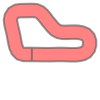

In [9]:
from helpers.utilities import convert_to_shapely

TRACK_VARS['TRACK_SHAPELY'] = convert_to_shapely(TRACK_VARS['TRACK_WAYPOINTS'])
TRACK_VARS['TRACK_IS_LOOP_RING'] = TRACK_VARS['TRACK_SHAPELY']['l_center_line'].is_ring
print(f"loop/ring: {TRACK_VARS['TRACK_IS_LOOP_RING']}")
TRACK_VARS['TRACK_SHAPELY']['road_poly']

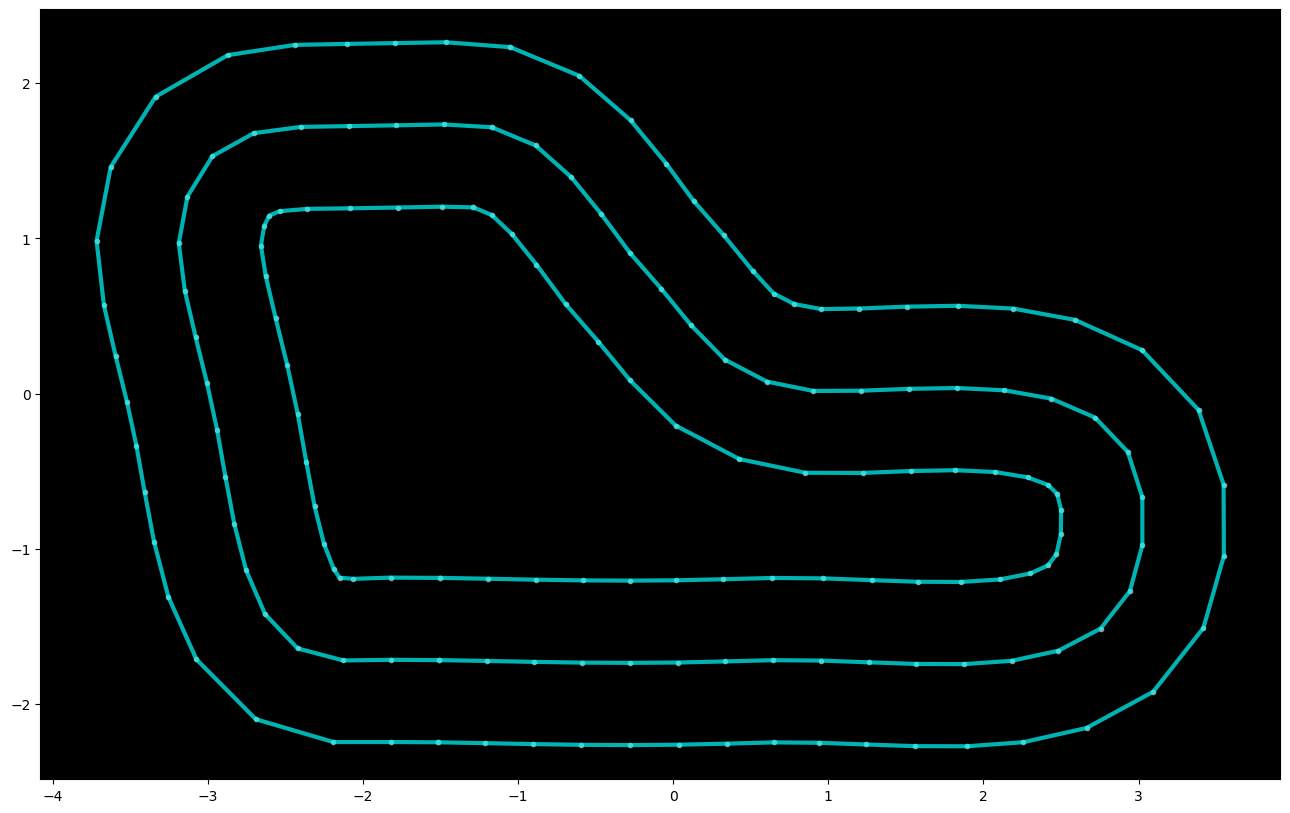

In [10]:
# Show plot of original track

from helpers.utilities import print_border

TRACK_VARS['TRACK_FIGURE'] = plt.figure(1, figsize=(16, 10))
ax = TRACK_VARS['TRACK_FIGURE'].add_subplot(111, facecolor='black')
plt.axis('equal')

print_border(
    ax,
    TRACK_VARS['TRACK_SHAPELY']['center_line'],
    TRACK_VARS['TRACK_SHAPELY']['inner_border'],
    TRACK_VARS['TRACK_SHAPELY']['outer_border']
)

## Reduce width of track

loop/ring: True


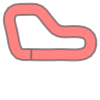

In [11]:
from helpers.utilities import x_perc_width

TRACK_VARS['TRACK_REDUCE_PERC'] = .8

reduce_waypoints = [x_perc_width(waypoint, perc_width=TRACK_VARS['TRACK_REDUCE_PERC']) for waypoint in TRACK_VARS['TRACK_WAYPOINTS']]
TRACK_VARS['TRACK_REDUCED_WAYPOINTS'] = np.asarray(reduce_waypoints)

TRACK_VARS['TRACK_REDUCED_SHAPELY'] = convert_to_shapely(TRACK_VARS['TRACK_REDUCED_WAYPOINTS'])
TRACK_VARS['TRACK_REDUCED_IS_LOOP_RING'] = TRACK_VARS['TRACK_REDUCED_SHAPELY']['l_center_line'].is_ring
print(f"loop/ring: {TRACK_VARS['TRACK_REDUCED_IS_LOOP_RING']}")
TRACK_VARS['TRACK_REDUCED_SHAPELY']['road_poly']

# Display the original track waypoints

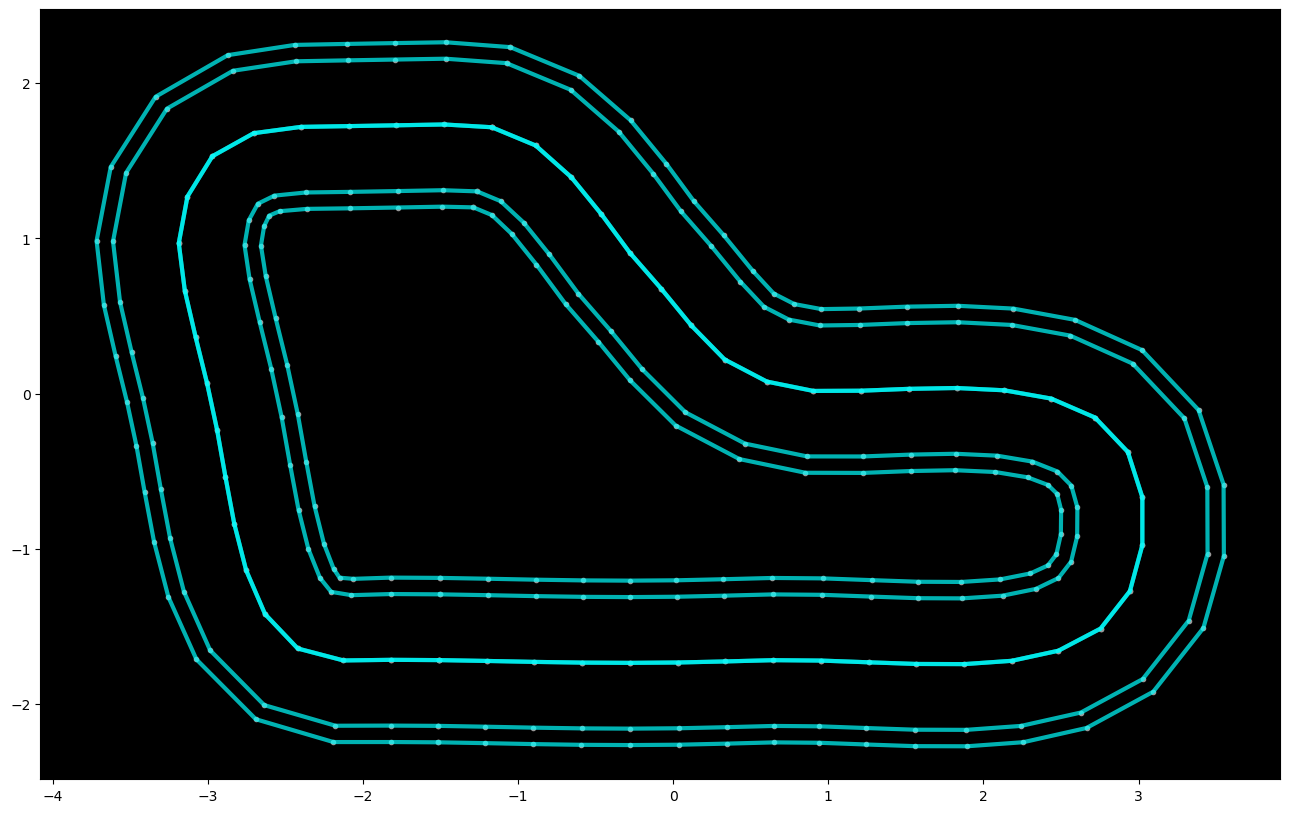

In [12]:
from helpers.utilities import print_border

TRACK_VARS['TRACK_FIGURE_OVERLAY'] = plt.figure(1, figsize=(16, 10))
ax = TRACK_VARS['TRACK_FIGURE_OVERLAY'].add_subplot(111, facecolor='black')
plt.axis('equal')

print_border(
    ax,
    TRACK_VARS['TRACK_SHAPELY']['center_line'],
    TRACK_VARS['TRACK_SHAPELY']['inner_border'],
    TRACK_VARS['TRACK_SHAPELY']['outer_border']
)

# Also print new border
print_border(
    ax,
    TRACK_VARS['TRACK_REDUCED_SHAPELY']['center_line'],
    TRACK_VARS['TRACK_REDUCED_SHAPELY']['inner_border'],
    TRACK_VARS['TRACK_REDUCED_SHAPELY']['outer_border']
)

## Calculate the race line!

In [13]:
RACE_LINE_VARS = {
    'RACE_LINE_SAVE_DIR': '../data/racelines',
    'RACE_LINE_XI_ITERATIONS': 8,  # Number of times to iterate each new race line point, keep this at 3-8 for best balance of performance and desired result
    'RACE_LINE_LINE_ITERATIONS': 1, #1500 , # Number of times to scan the entire race track to iterate, 500 will get a good start, 1500 will be closer to optimal result
    'RACE_LINE_LENGTH_ORIGINAL': TRACK_VARS['TRACK_SHAPELY']['l_center_line'].length,
    'RACE_LINE_ADDED_CLOSE_LOOP_WAYPOINT': None,
    'RACE_LINE_IMPROVED': None,
    'RACE_LINE_IMPROVED_FIG': None,
    'RACE_LINE_IMPROVED_LENGTH': None,
    'RACE_LINE_IMPROVED_LOOP_RACE_LINE_CLEAN': None
}

In [14]:
from helpers.utilities import improve_race_line_runner

RACE_LINE_VARS['RACE_LINE_IMPROVED'] = improve_race_line_runner(
    TRACK_VARS['TRACK_REDUCED_SHAPELY'],
    RACE_LINE_VARS['RACE_LINE_LINE_ITERATIONS'],
    RACE_LINE_VARS['RACE_LINE_XI_ITERATIONS']
)

56


/home/jmagady.fam@ad.recitsols.com/Development/repositories/github/bohica-labs/DeepRacer/NoteBooks/helpers/utilities/curve.py:39: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arccos(np.dot(vec21, vec23) / (norm21 * norm23))
/home/jmagady.fam@ad.recitsols.com/Development/repositories/github/bohica-labs/DeepRacer/NoteBooks/helpers/utilities/curve.py:39: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.dot(vec21, vec23) / (norm21 * norm23))


These should be the same:  ((56, 2), (56, 2))
Original centerline length: 16.60
New race line length: 16.46


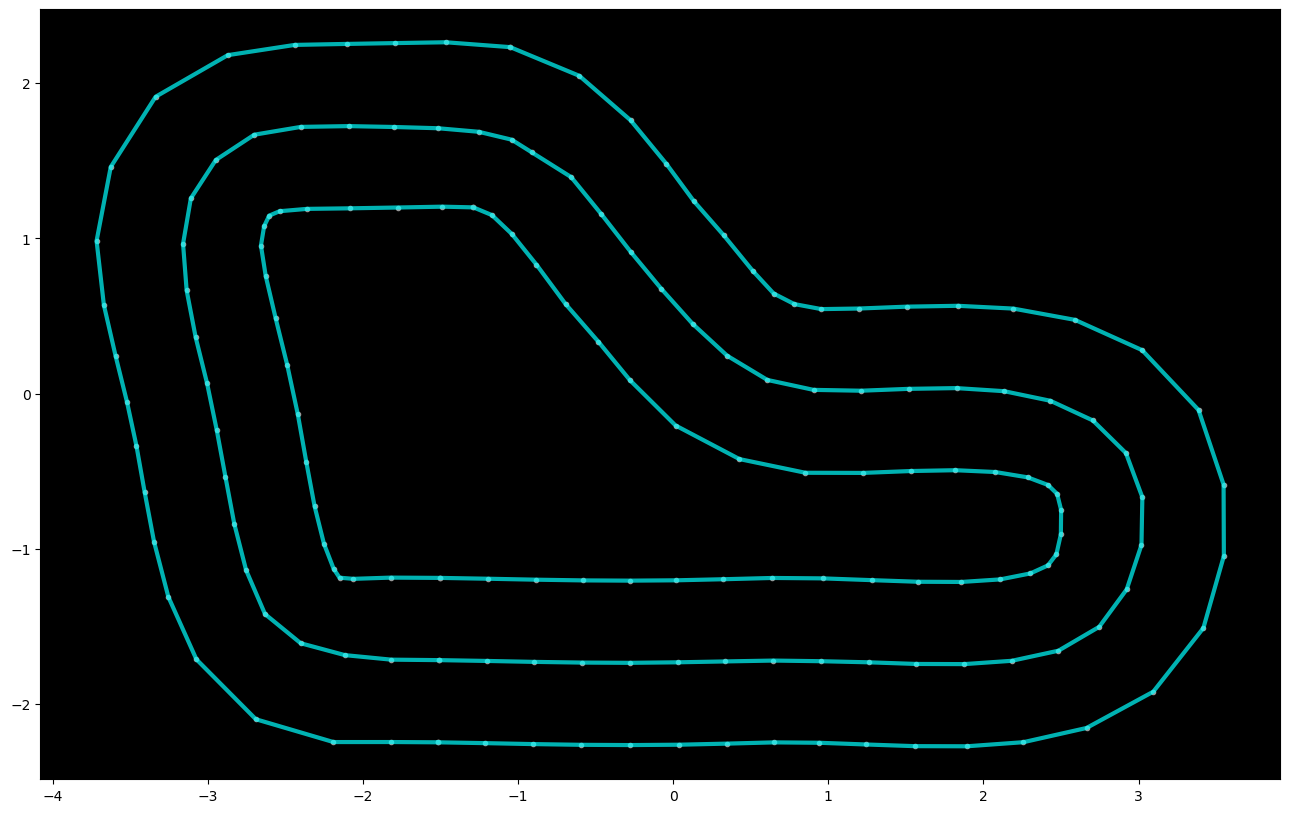

In [15]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE'] = np.append(RACE_LINE_VARS['RACE_LINE_IMPROVED'], [RACE_LINE_VARS['RACE_LINE_IMPROVED'][0]], axis=0)
RACE_LINE_VARS['RACE_LINE_ADDED_CLOSE_LOOP_WAYPOINT'] = True
RACE_LINE_VARS['RACE_LINE_IMPROVED_LENGTH'] = LineString(RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE']).length



# These should be the same
print("These should be the same: ", (TRACK_VARS['TRACK_SHAPELY']['center_line'].shape, RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE'].shape))
print("Original centerline length: %0.2f" % RACE_LINE_VARS['RACE_LINE_LENGTH_ORIGINAL'])
print("New race line length: %0.2f" % RACE_LINE_VARS['RACE_LINE_IMPROVED_LENGTH'])

RACE_LINE_VARS['RACE_LINE_IMPROVED_FIG'] = plt.figure(1, figsize=(16, 10))
ax = RACE_LINE_VARS['RACE_LINE_IMPROVED_FIG'].add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(
    ax,
    RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE'],
    TRACK_VARS['TRACK_SHAPELY']['inner_border'],
    TRACK_VARS['TRACK_SHAPELY']['outer_border']
)

# Also print new border
#print_border(ax, loop_race_line, inner_border_new, outer_border_new)

# Action Space

- Change ```LOOK_AHEAD_POINTS``` to influence how many points the algorithm looks ahead (the higher, the sooner the car will start to break)
- Change ```MIN_SPEED``` and ```MAX_SPEED``` to fit the track and model !
- Change ```LOOK_AHEAD_POINTS_LIST``` to the list of look ahead figs you want to create

In [16]:
OPTIMAL_SPEED_VARS = {
    "OPTIMAL_SPEED_TARGET_LOOK_AHEAD_POINTS": 5,  # Sane default
    "OPTIMAL_SPEED_LOOK_AHEAD_POINTS_LIST": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Change this to the list of figs you want to see, it needs to always start with 0
    "OPTIMAL_SPEED_MIN_SPEED": 1.3,
    "OPTIMAL_SPEED_MAX_SPEED": 4.0,
    "OPTIMAL_SPEED_VELOCITY": {},
    "OPTIMAL_SPEED_X_Y": None,
    "OPTIMAL_SPEED_VELOCITY_FIGS": None,
    "OPTIMAL_SPEED_DISTANCE_BETWEEN": None,
    "OPTIMAL_SPEED_TIME_BETWEEN": None,
    "OPTIMAL_SPEED_STD_STEERING": None,
    "OPTIMAL_SPEED_STD_VELOCITY": None,
    "OPTIMAL_SPEED_RESAMPLE_SIZE": 1000,
    "OPTIMAL_SPEED_N_CLUSTERS": 21-2,  # remove 2 actions from KMeans so that low speed & high steering actions can be manually included
    "OPTIMAL_SPEED_SEED": 1,  # Makes the randomness deterministic
}

In [17]:
print(OPTIMAL_SPEED_VARS["OPTIMAL_SPEED_X_Y"])

None


## Clean the Optimal Race Line

In [18]:
from helpers.utilities.actionspace import get_x_y

RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE_CLEAN'] = RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE'].tolist()[:-1]
OPTIMAL_SPEED_VARS["OPTIMAL_SPEED_X_Y"] = get_x_y(RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE_CLEAN'])

## Calculate Standard Deviations for

/tmp/ipykernel_1206477/3768728258.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<Axes: ylabel='Density'>

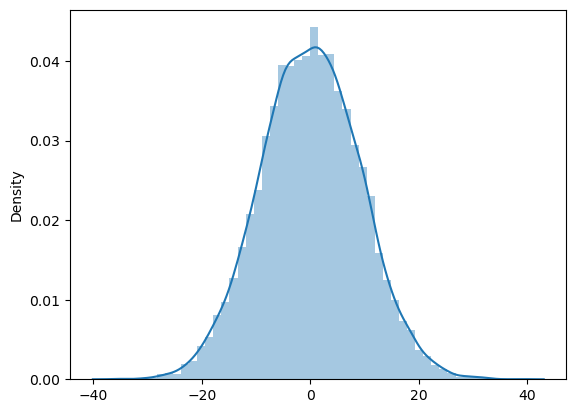

In [19]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
OPTIMAL_SPEED_VARS["OPTIMAL_SPEED_STD_STEERING"] = -15 / stats.norm.ppf(0.05)
sns.distplot(
    np.random.normal(
        0,
        OPTIMAL_SPEED_VARS["OPTIMAL_SPEED_STD_STEERING"],
        10000
    )
)

/tmp/ipykernel_1206477/2671485520.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/jmagady.fam@ad.recitsols.com/miniconda3/envs/DeepRacer/lib/python3.10/site-packages/seaborn/distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


<Axes: ylabel='Density'>

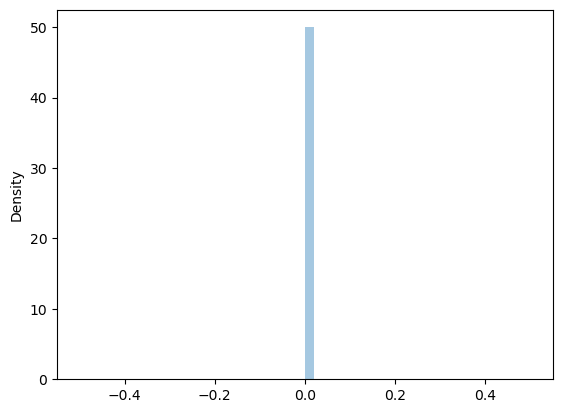

In [20]:
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
OPTIMAL_SPEED_VARS["OPTIMAL_SPEED_STD_VELOCITY"] = -0.25 / stats.norm.ppf(0.00)
sns.distplot(
    np.random.normal(
        0,
        OPTIMAL_SPEED_VARS["OPTIMAL_SPEED_STD_VELOCITY"],
        10000
    )
)

## Calculate Velocity and other vars

In [21]:
from helpers.utilities.actionspace import optimal_velocity_runner

OPTIMAL_SPEED_VARS["OPTIMAL_SPEED_VELOCITY"] = optimal_velocity_runner(OPTIMAL_SPEED_VARS, RACE_LINE_VARS)

Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357
Constant multiple for optimal speed: 1.7190833571764357


## Visualize

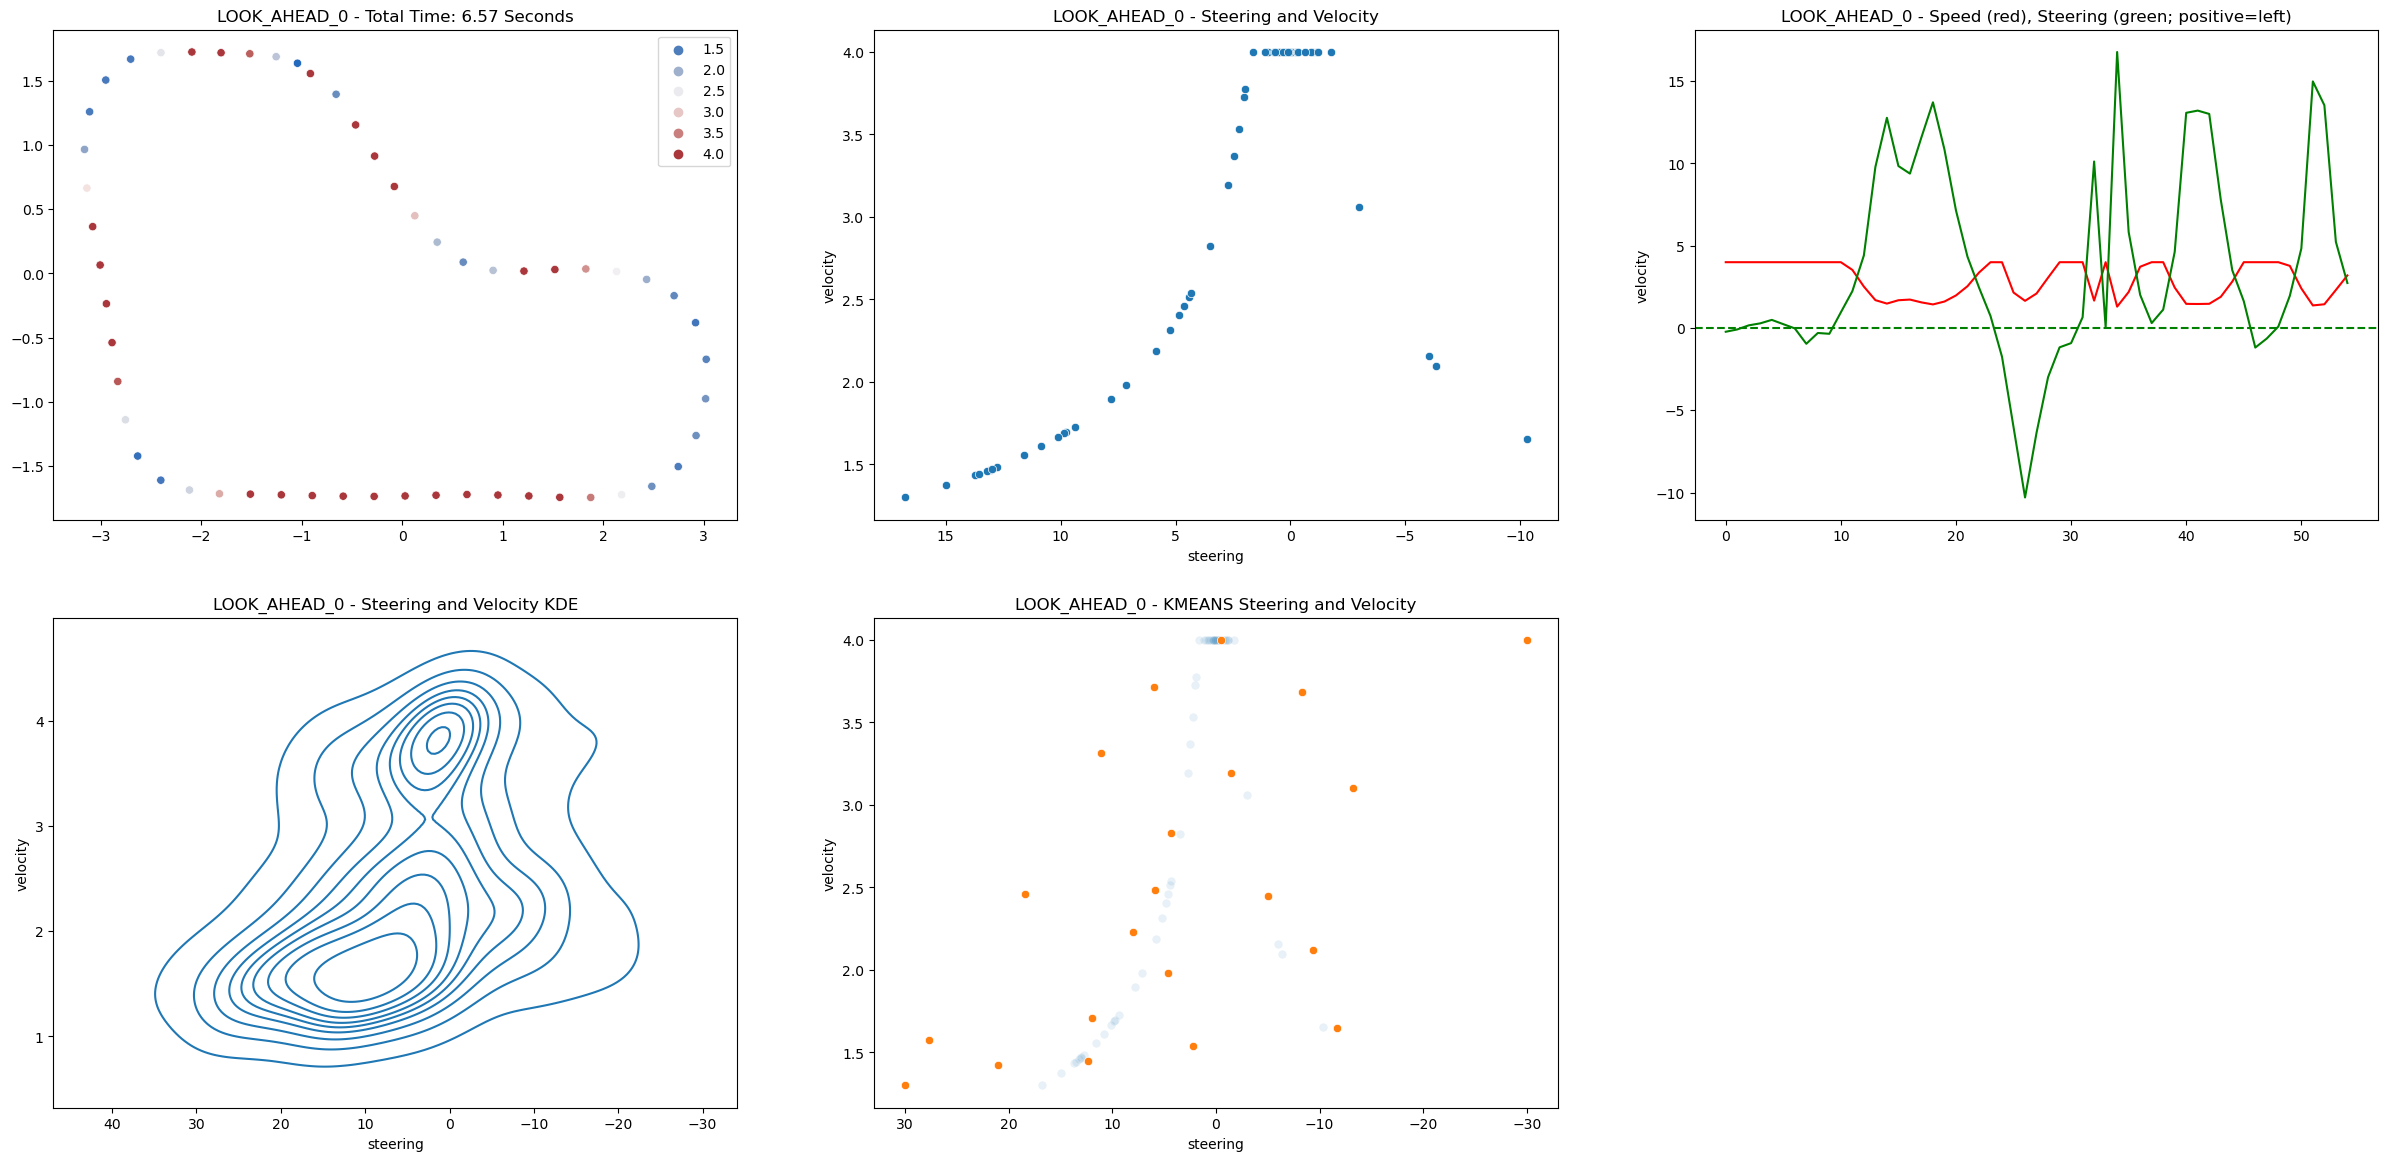

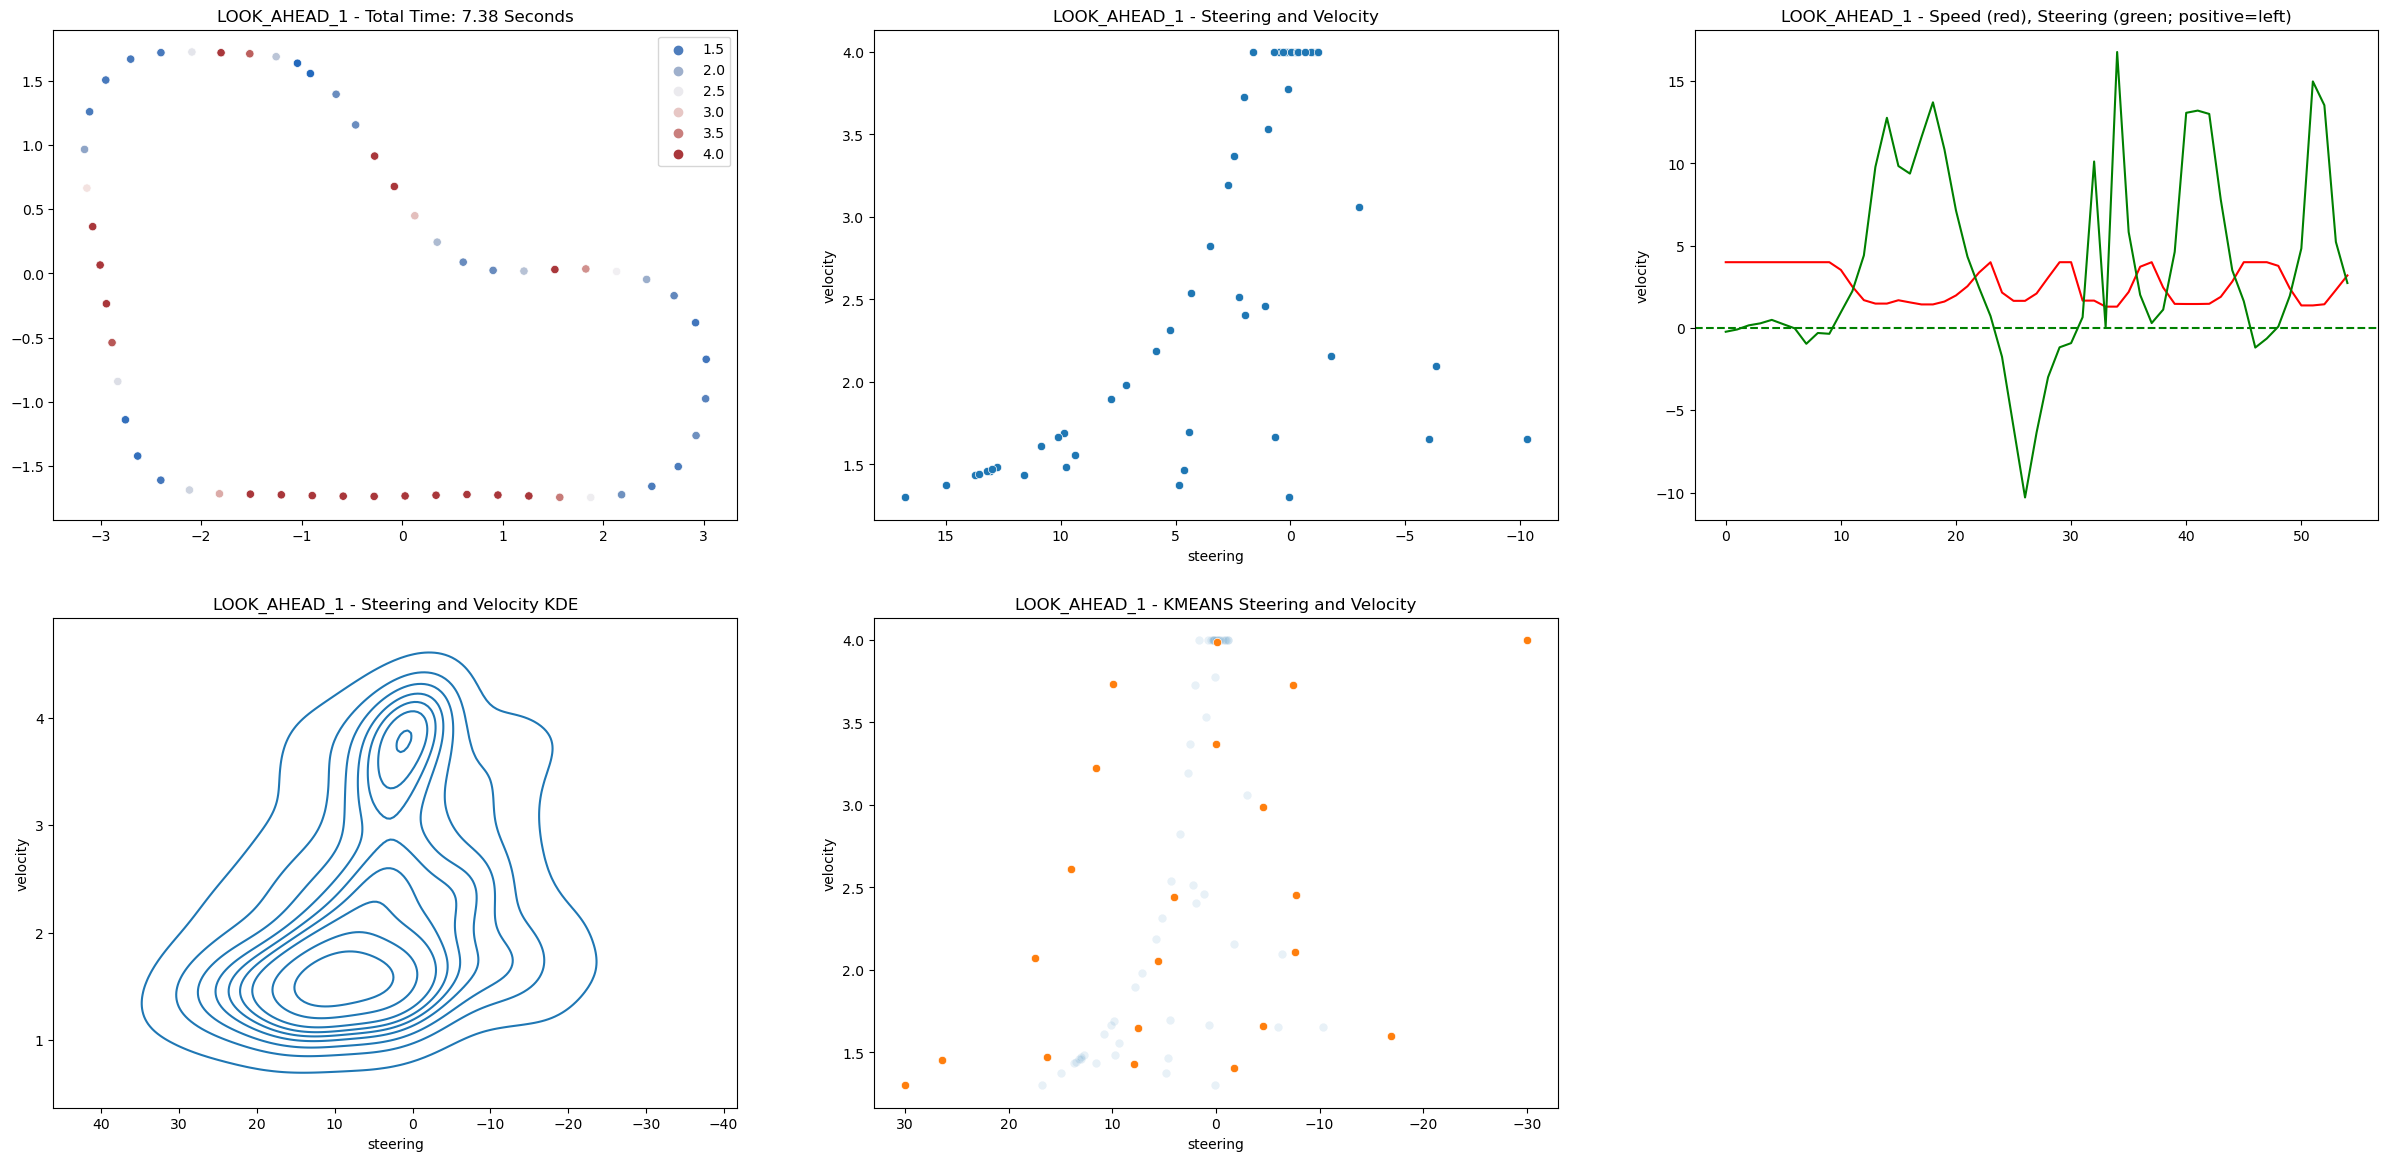

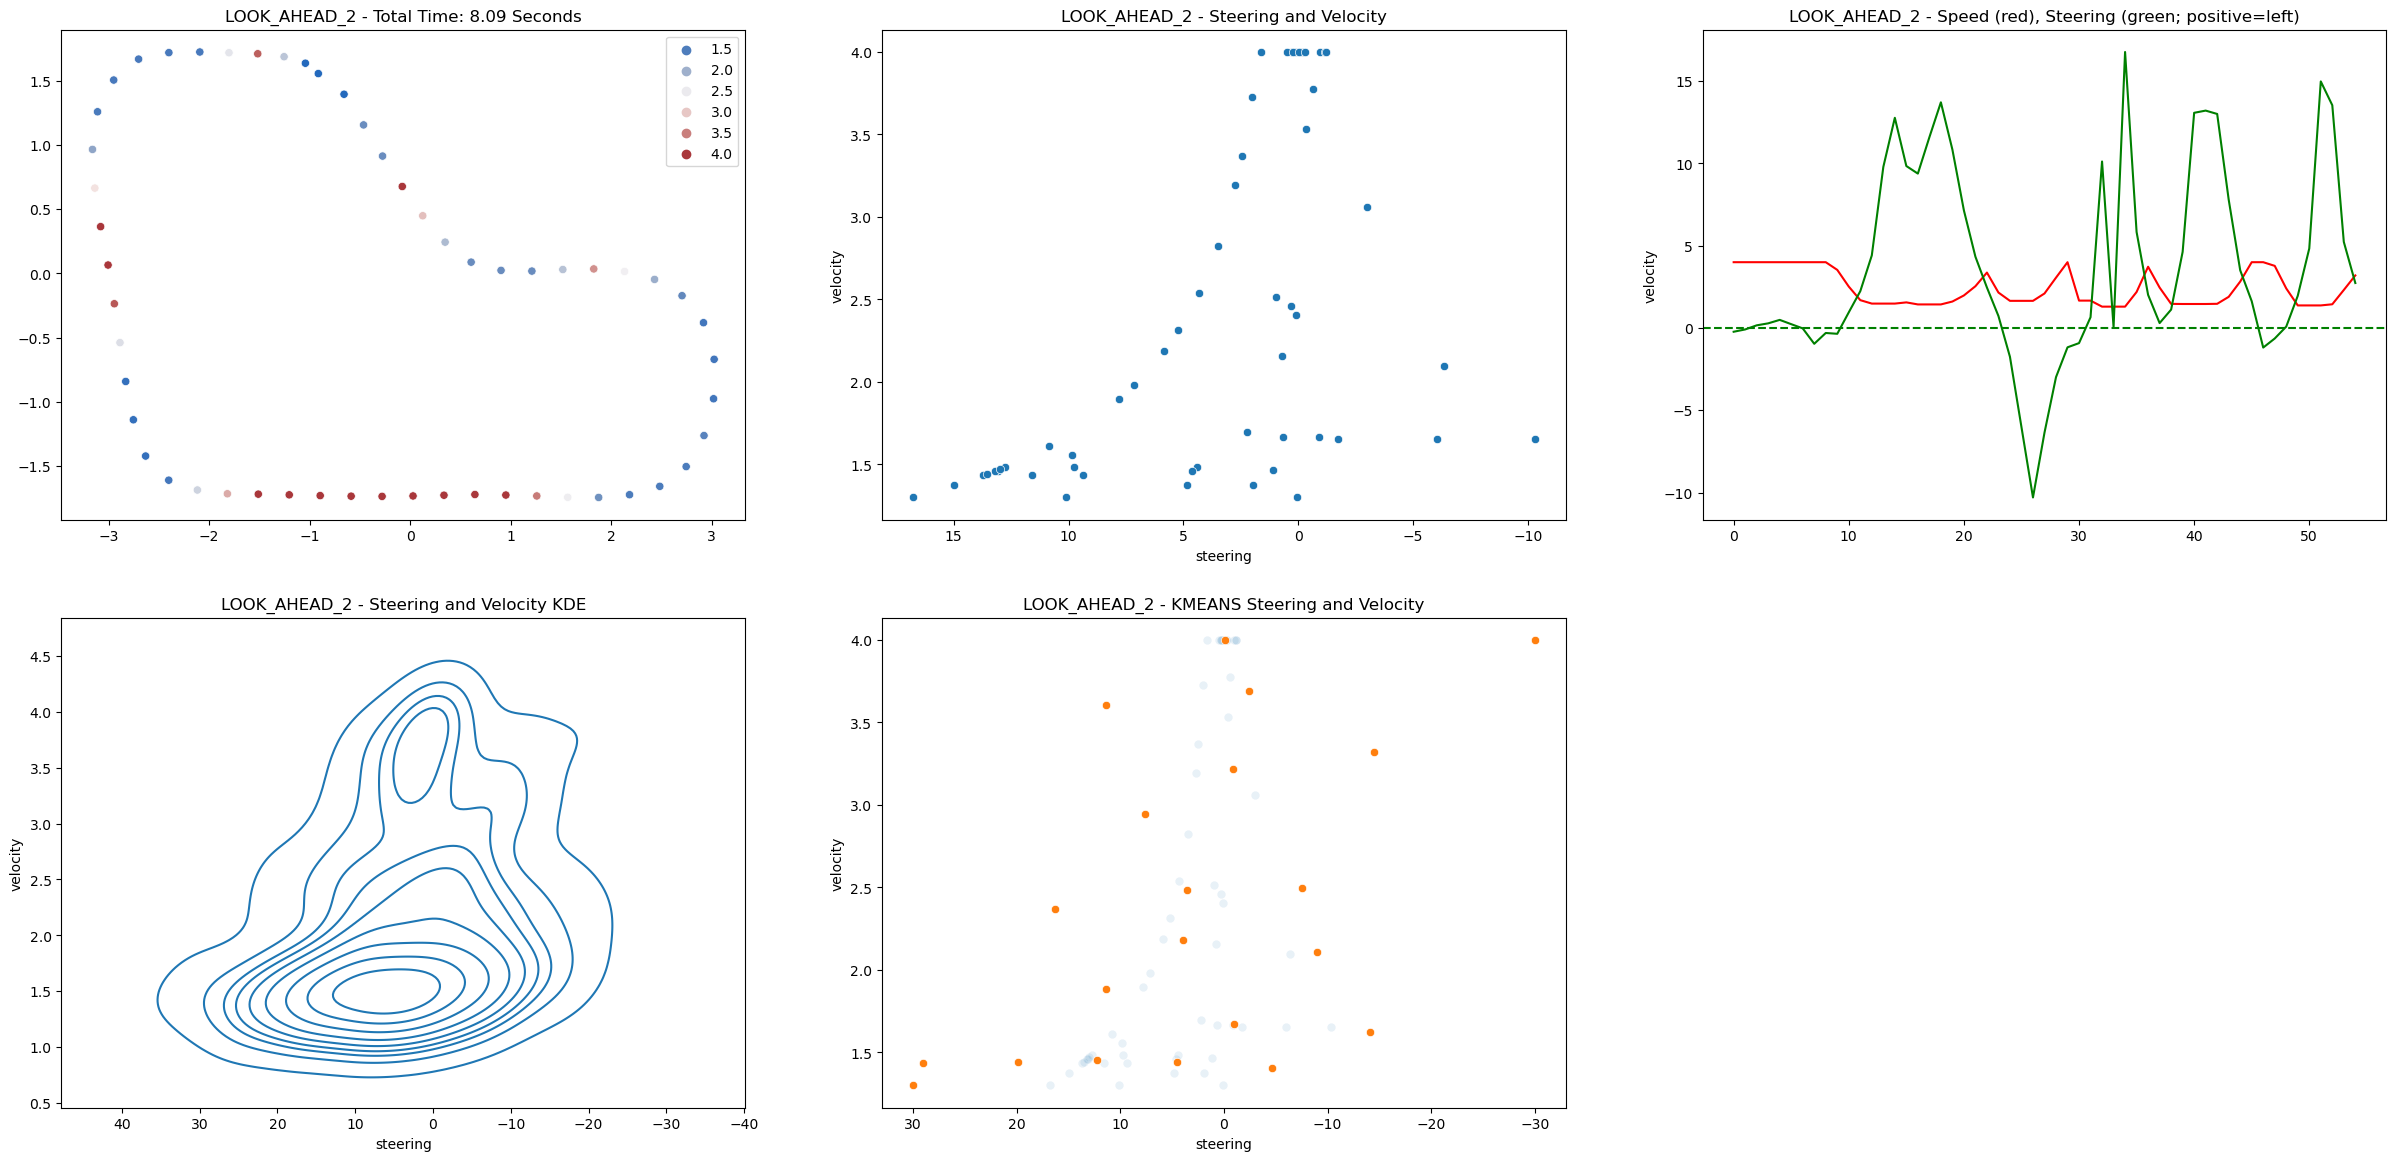

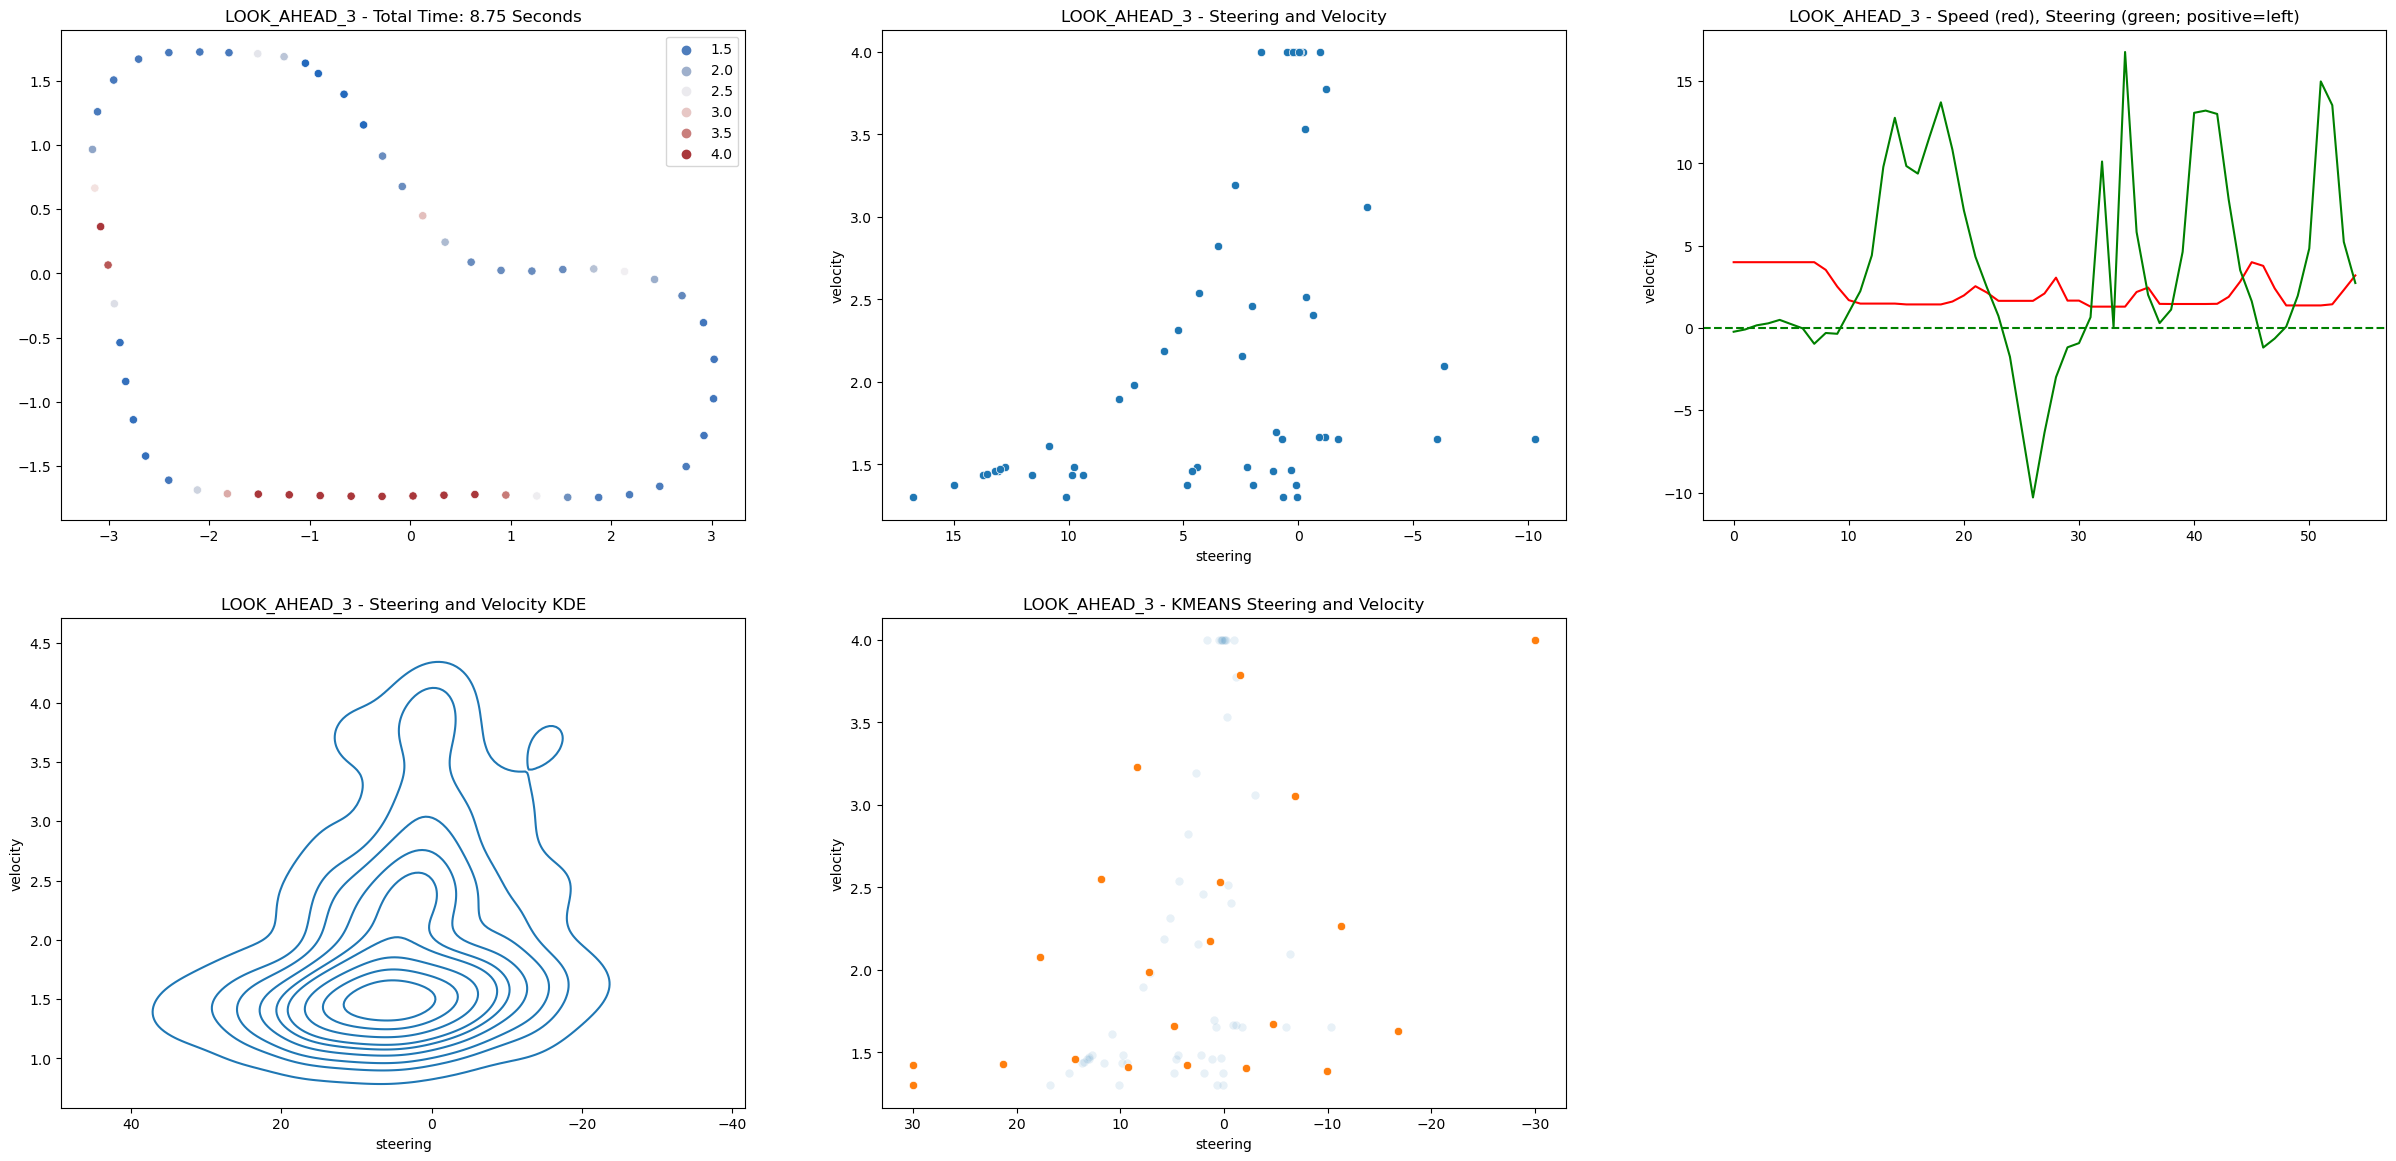

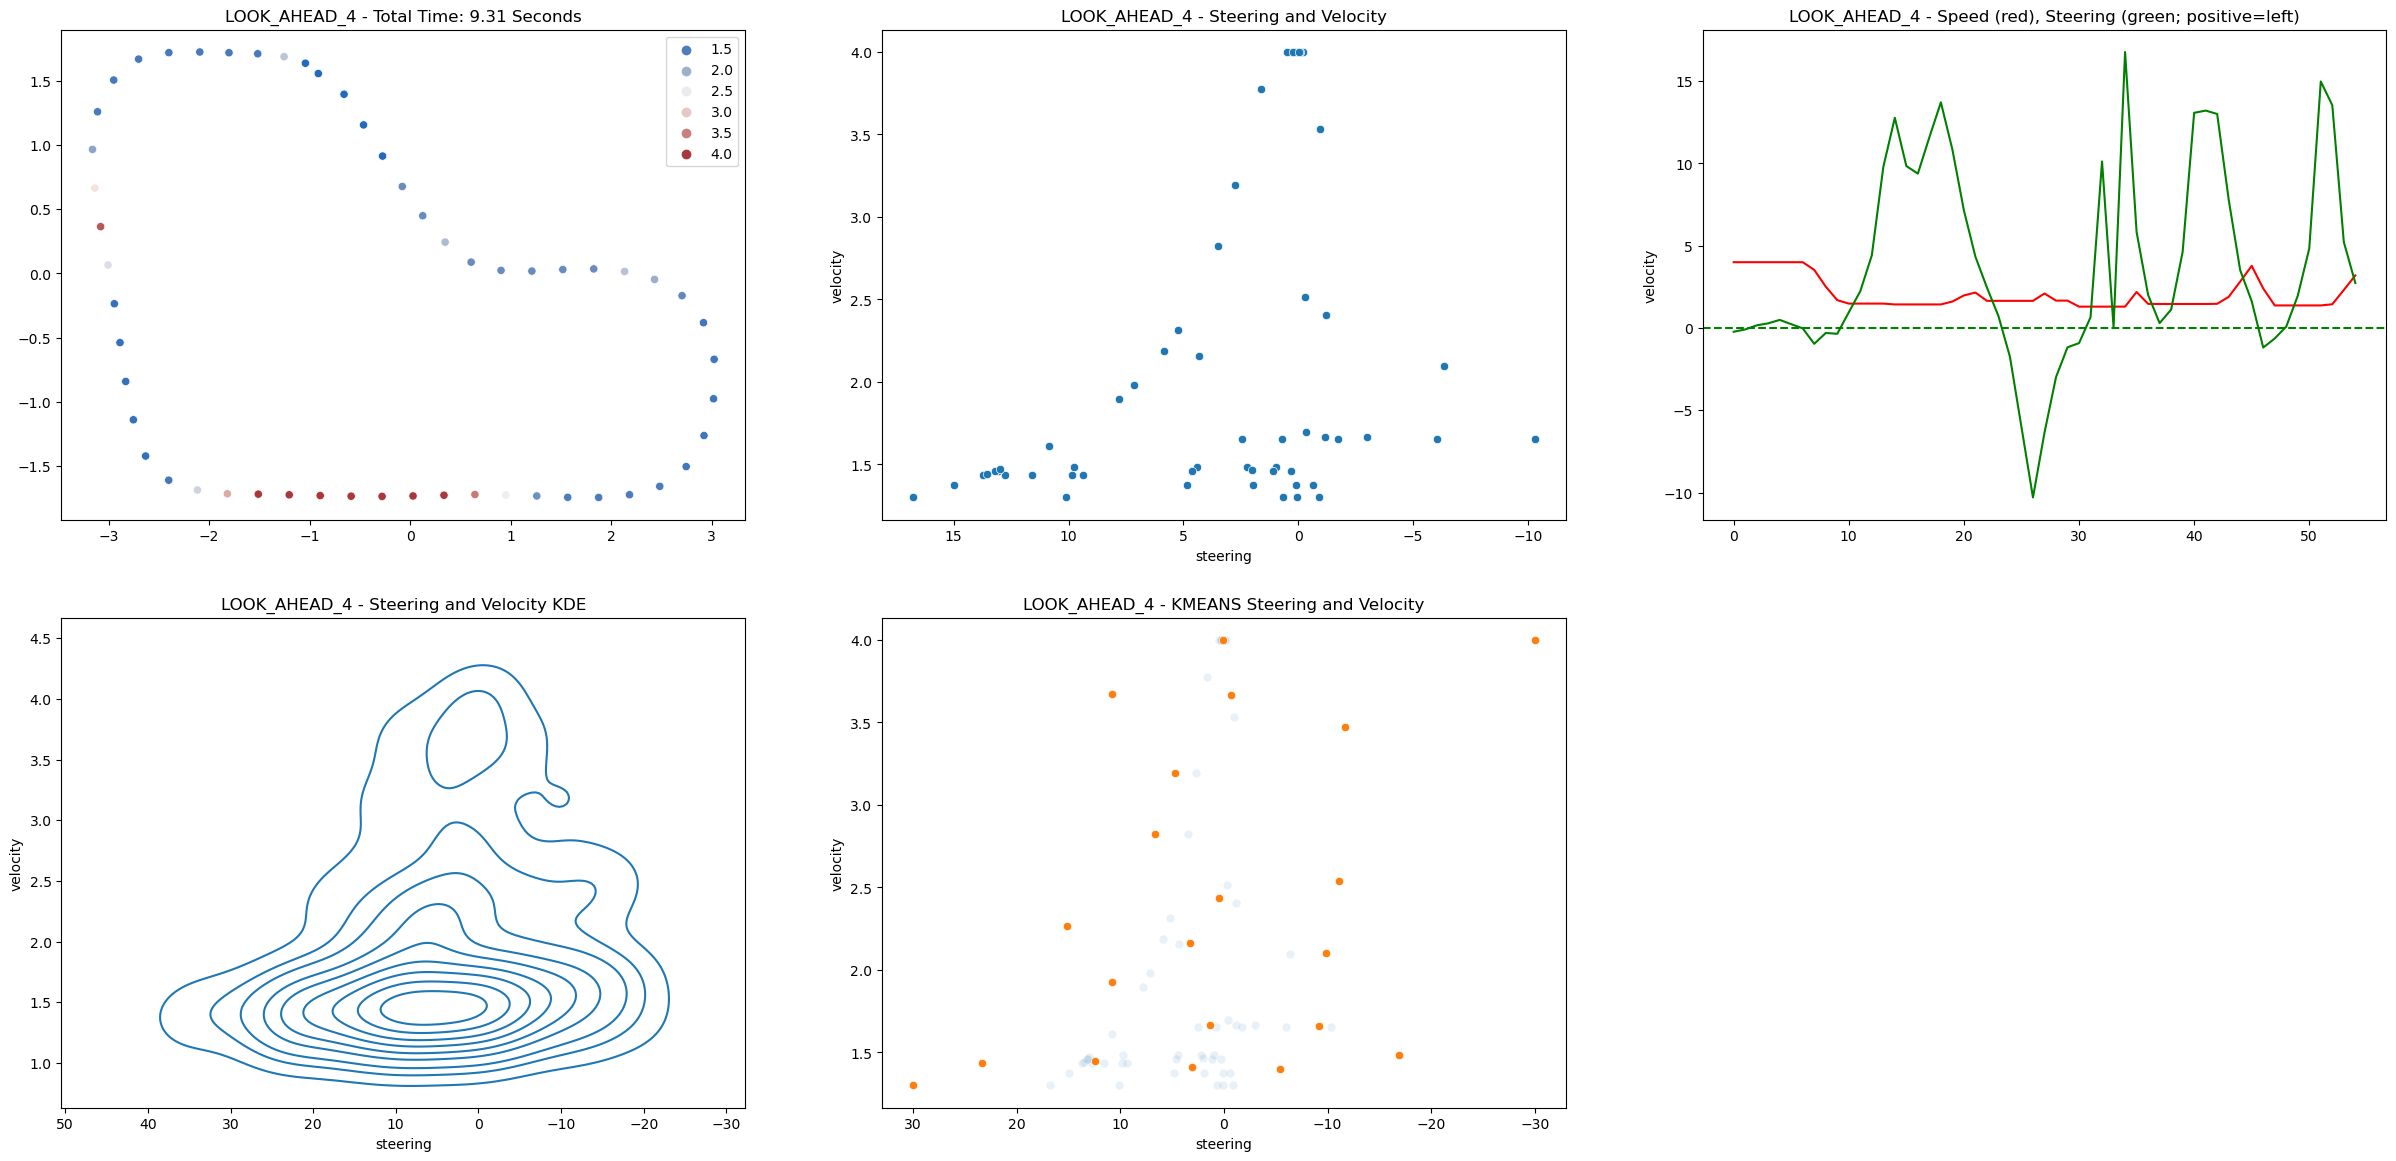

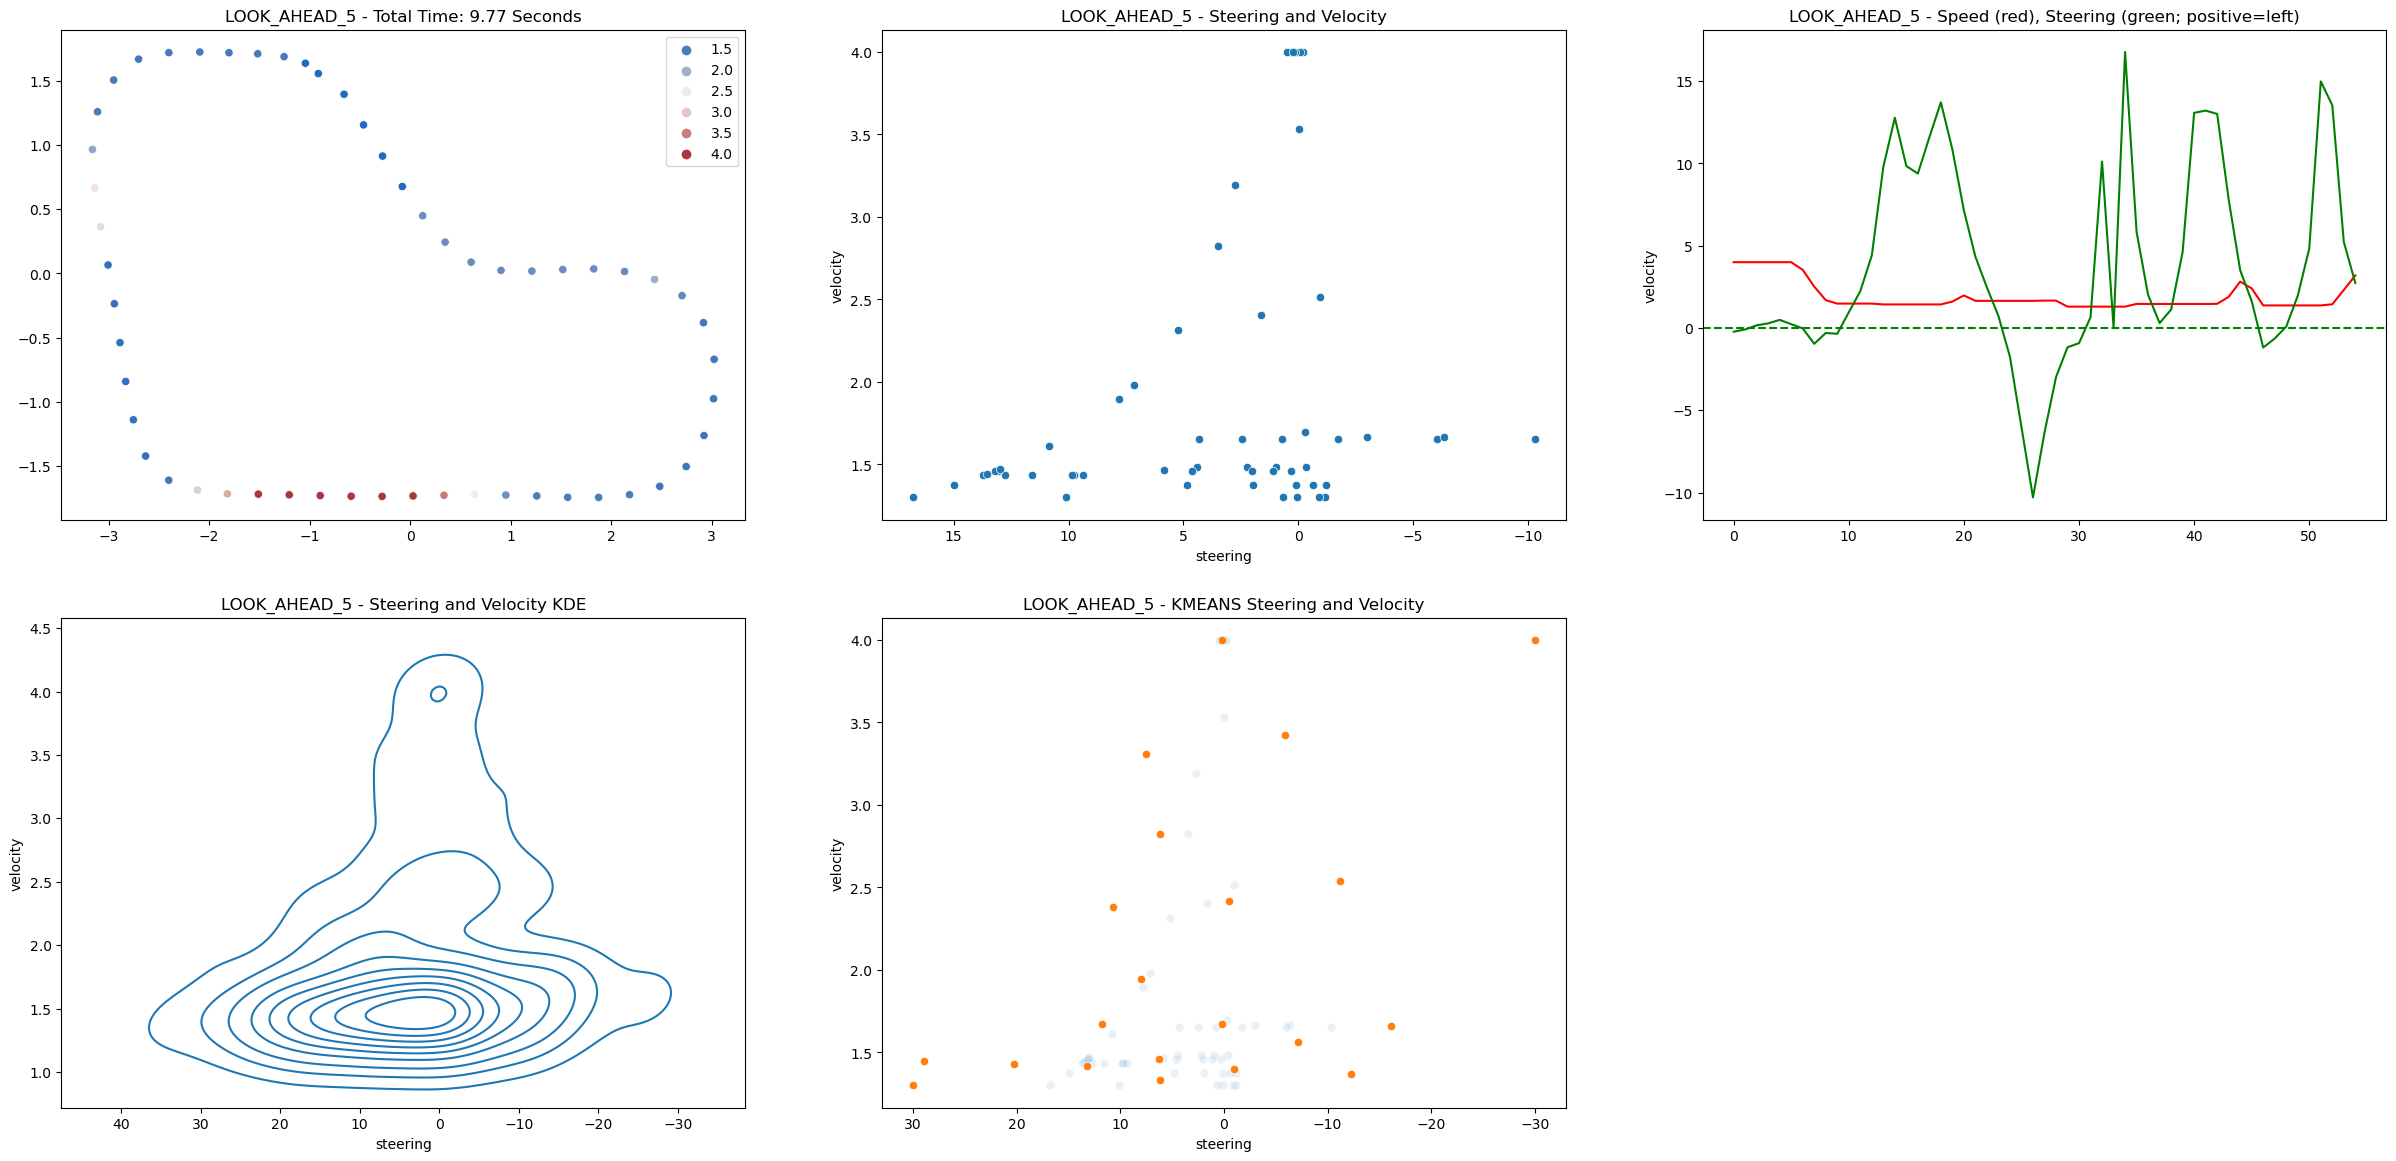

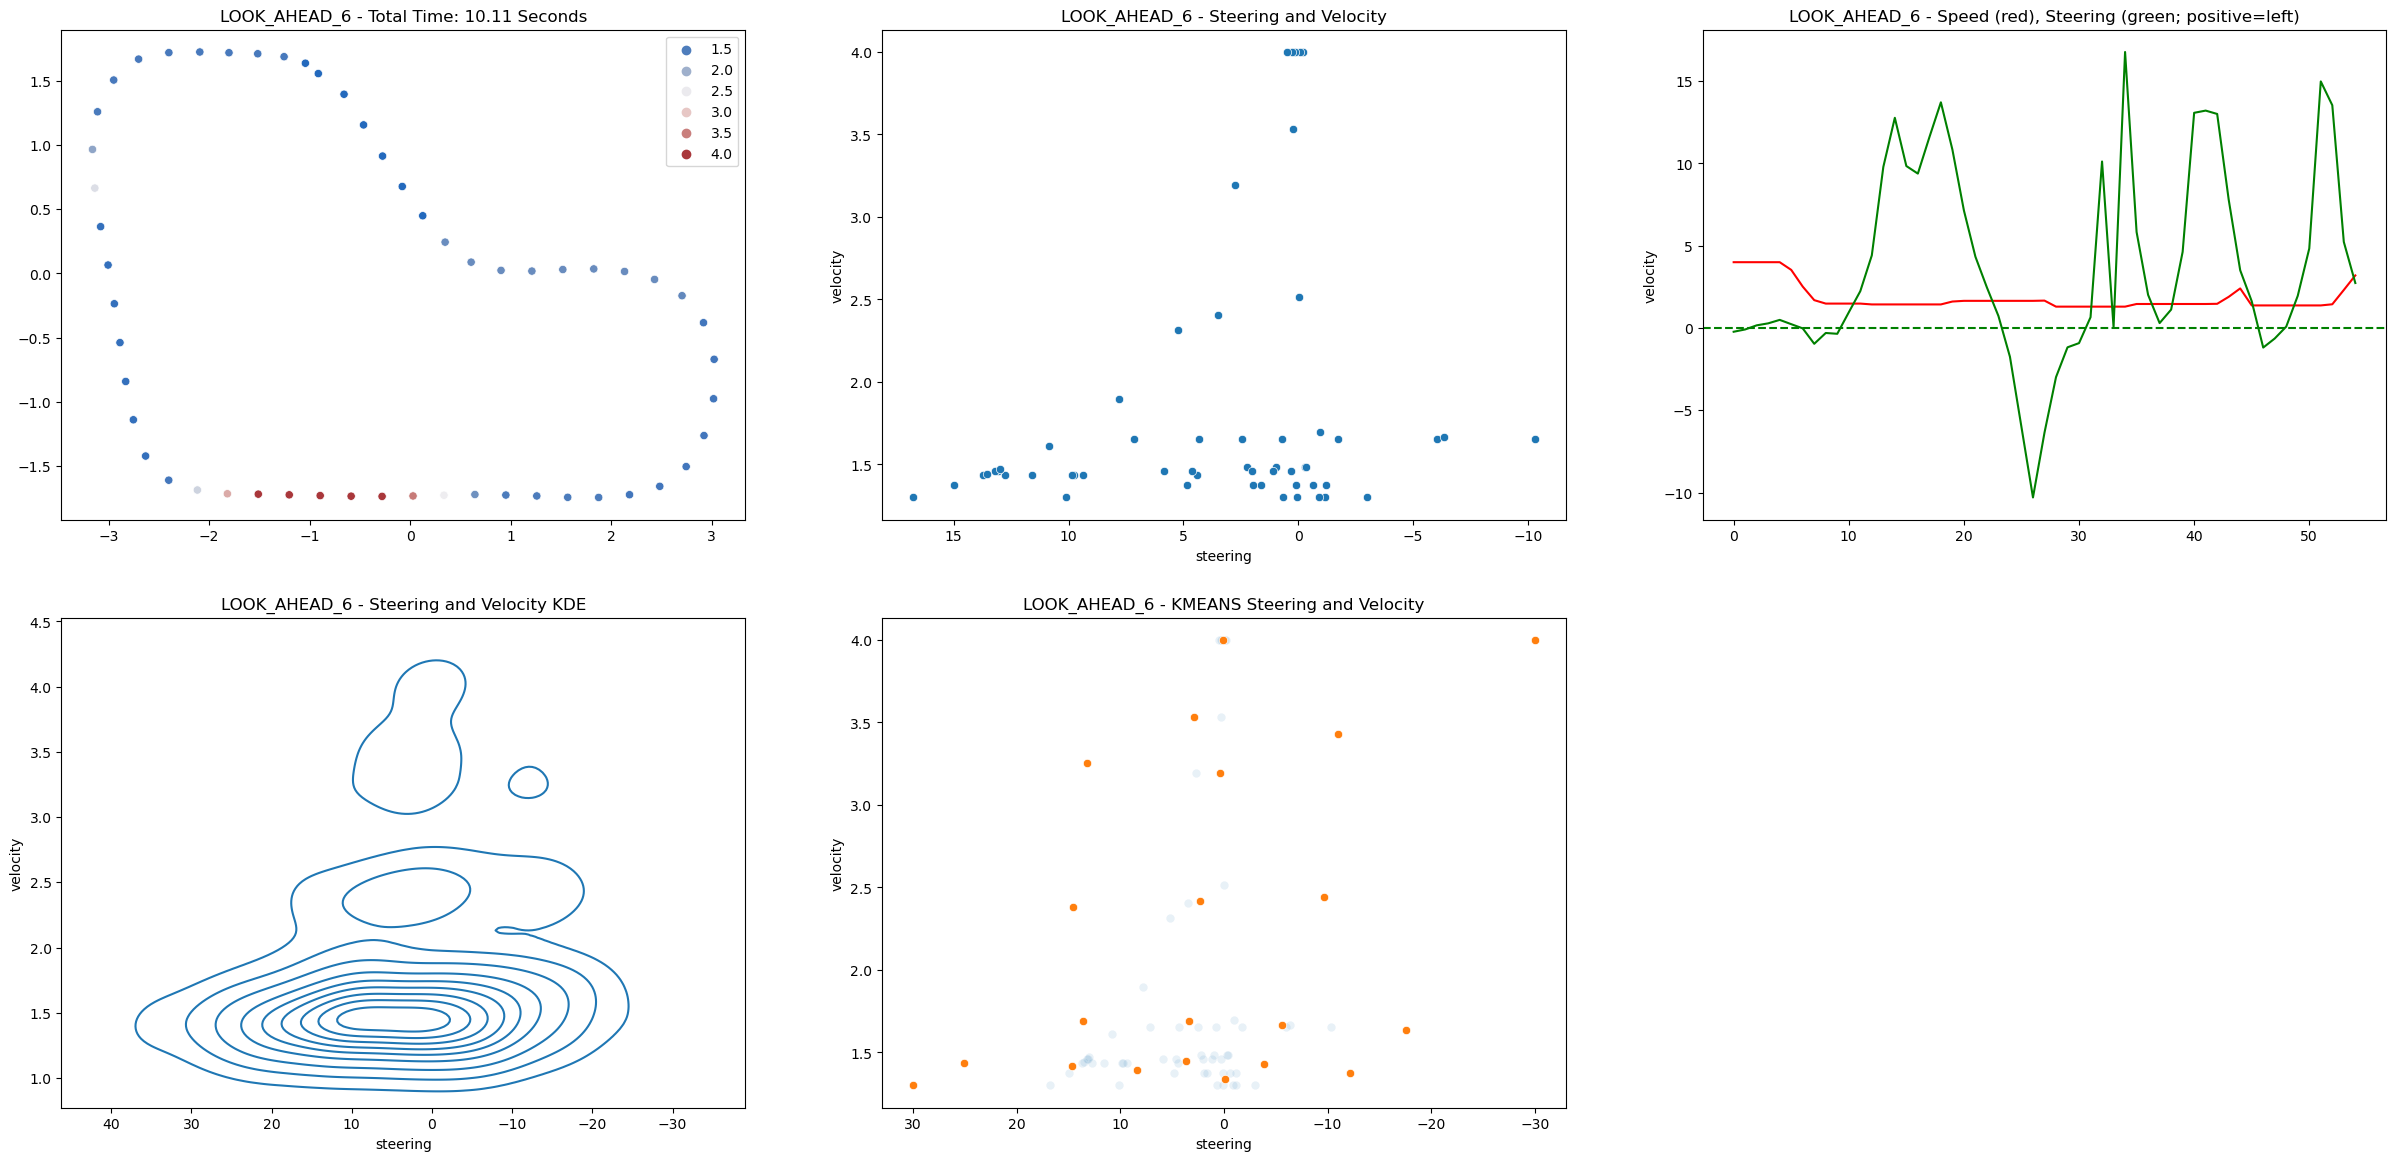

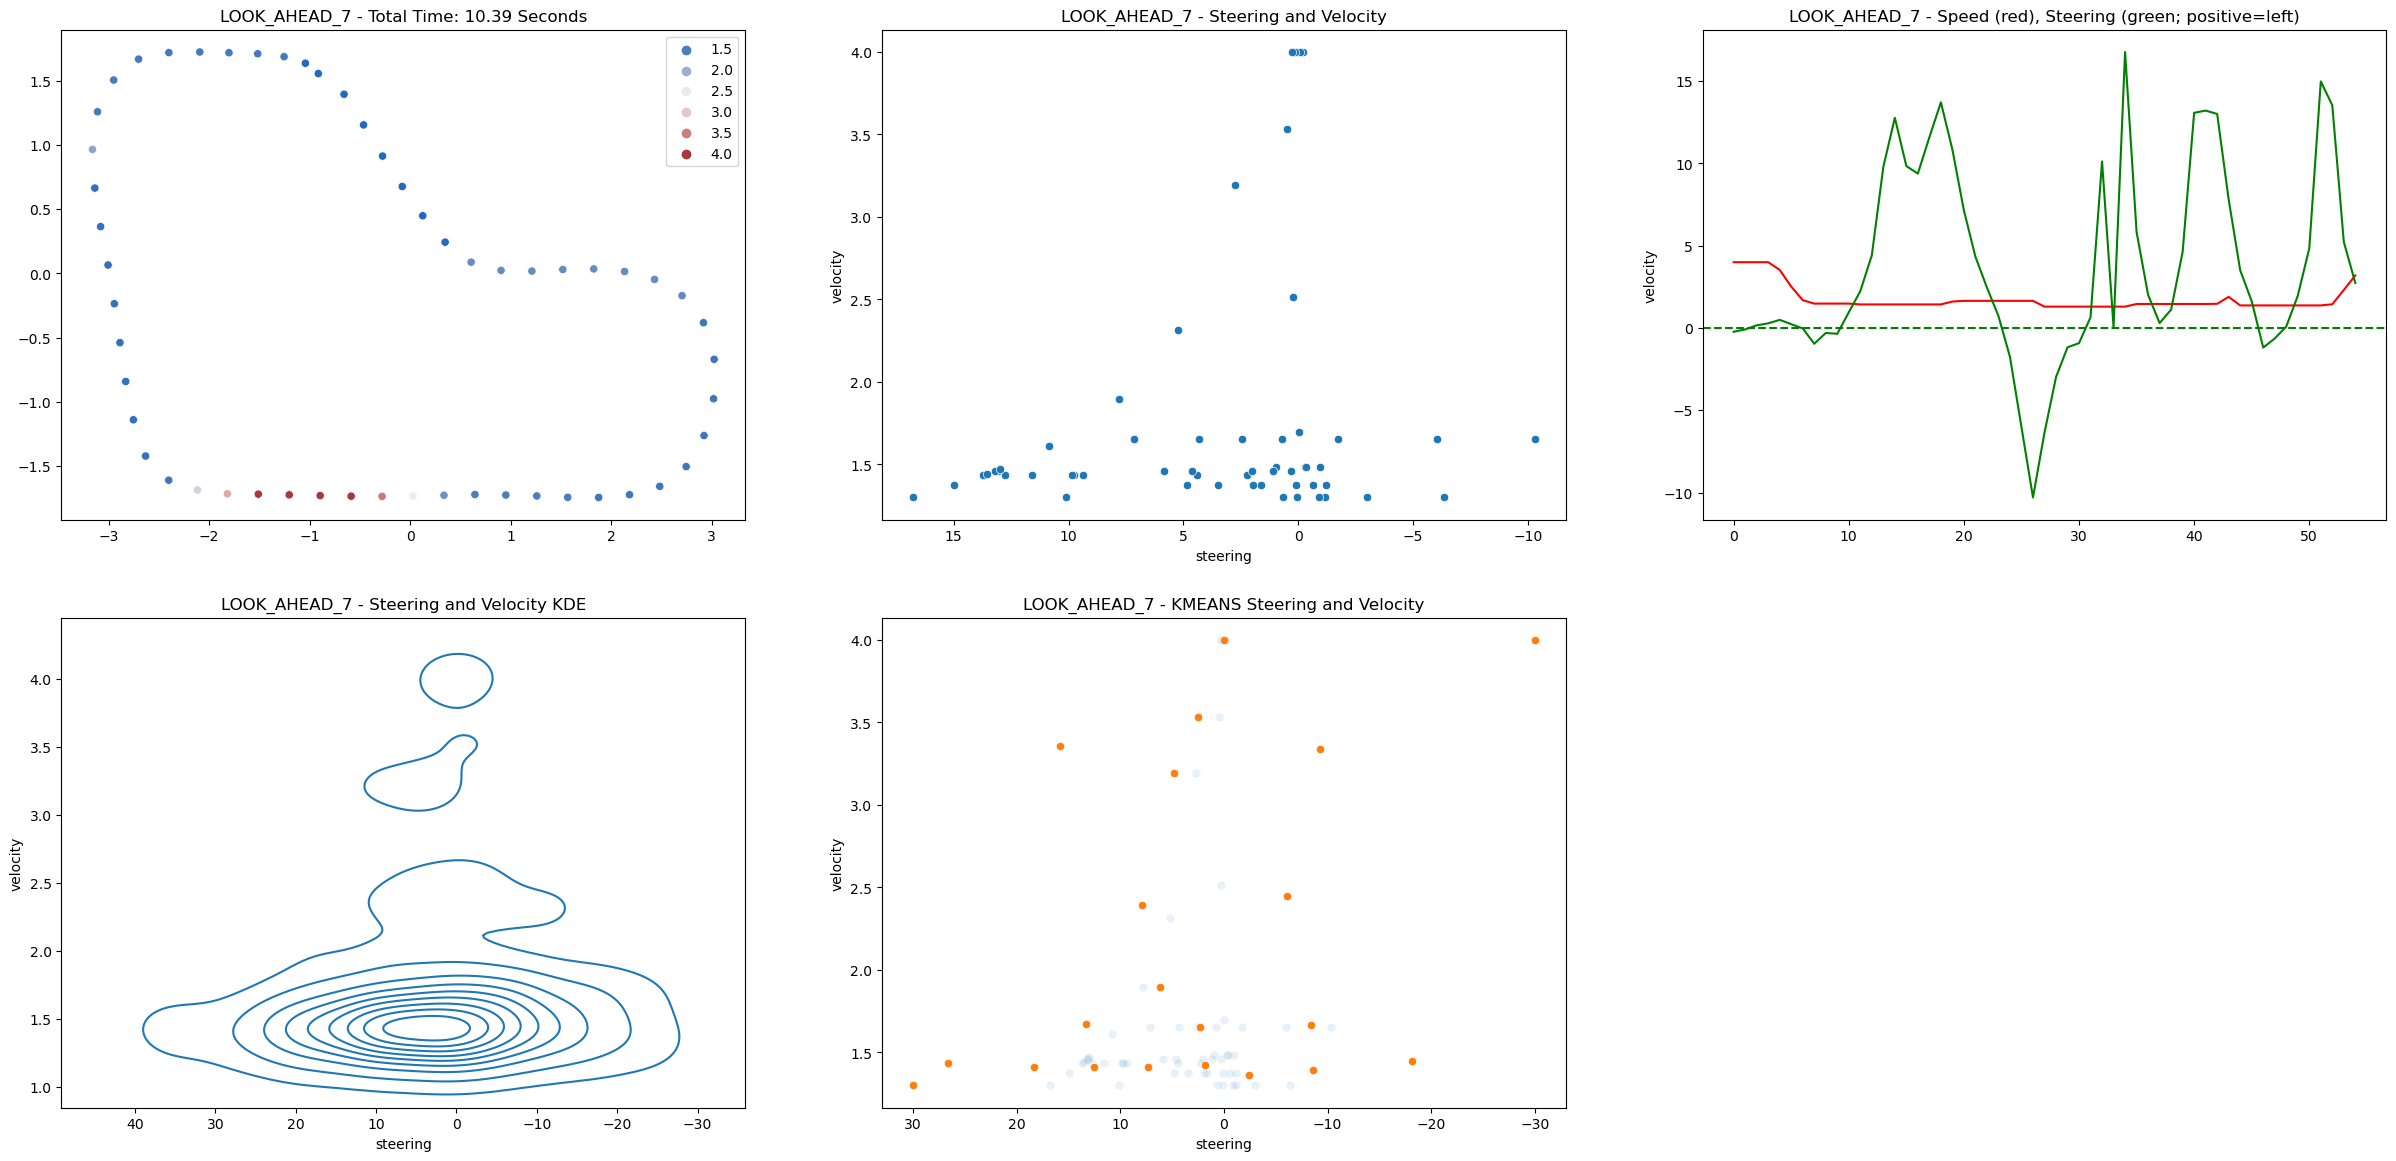

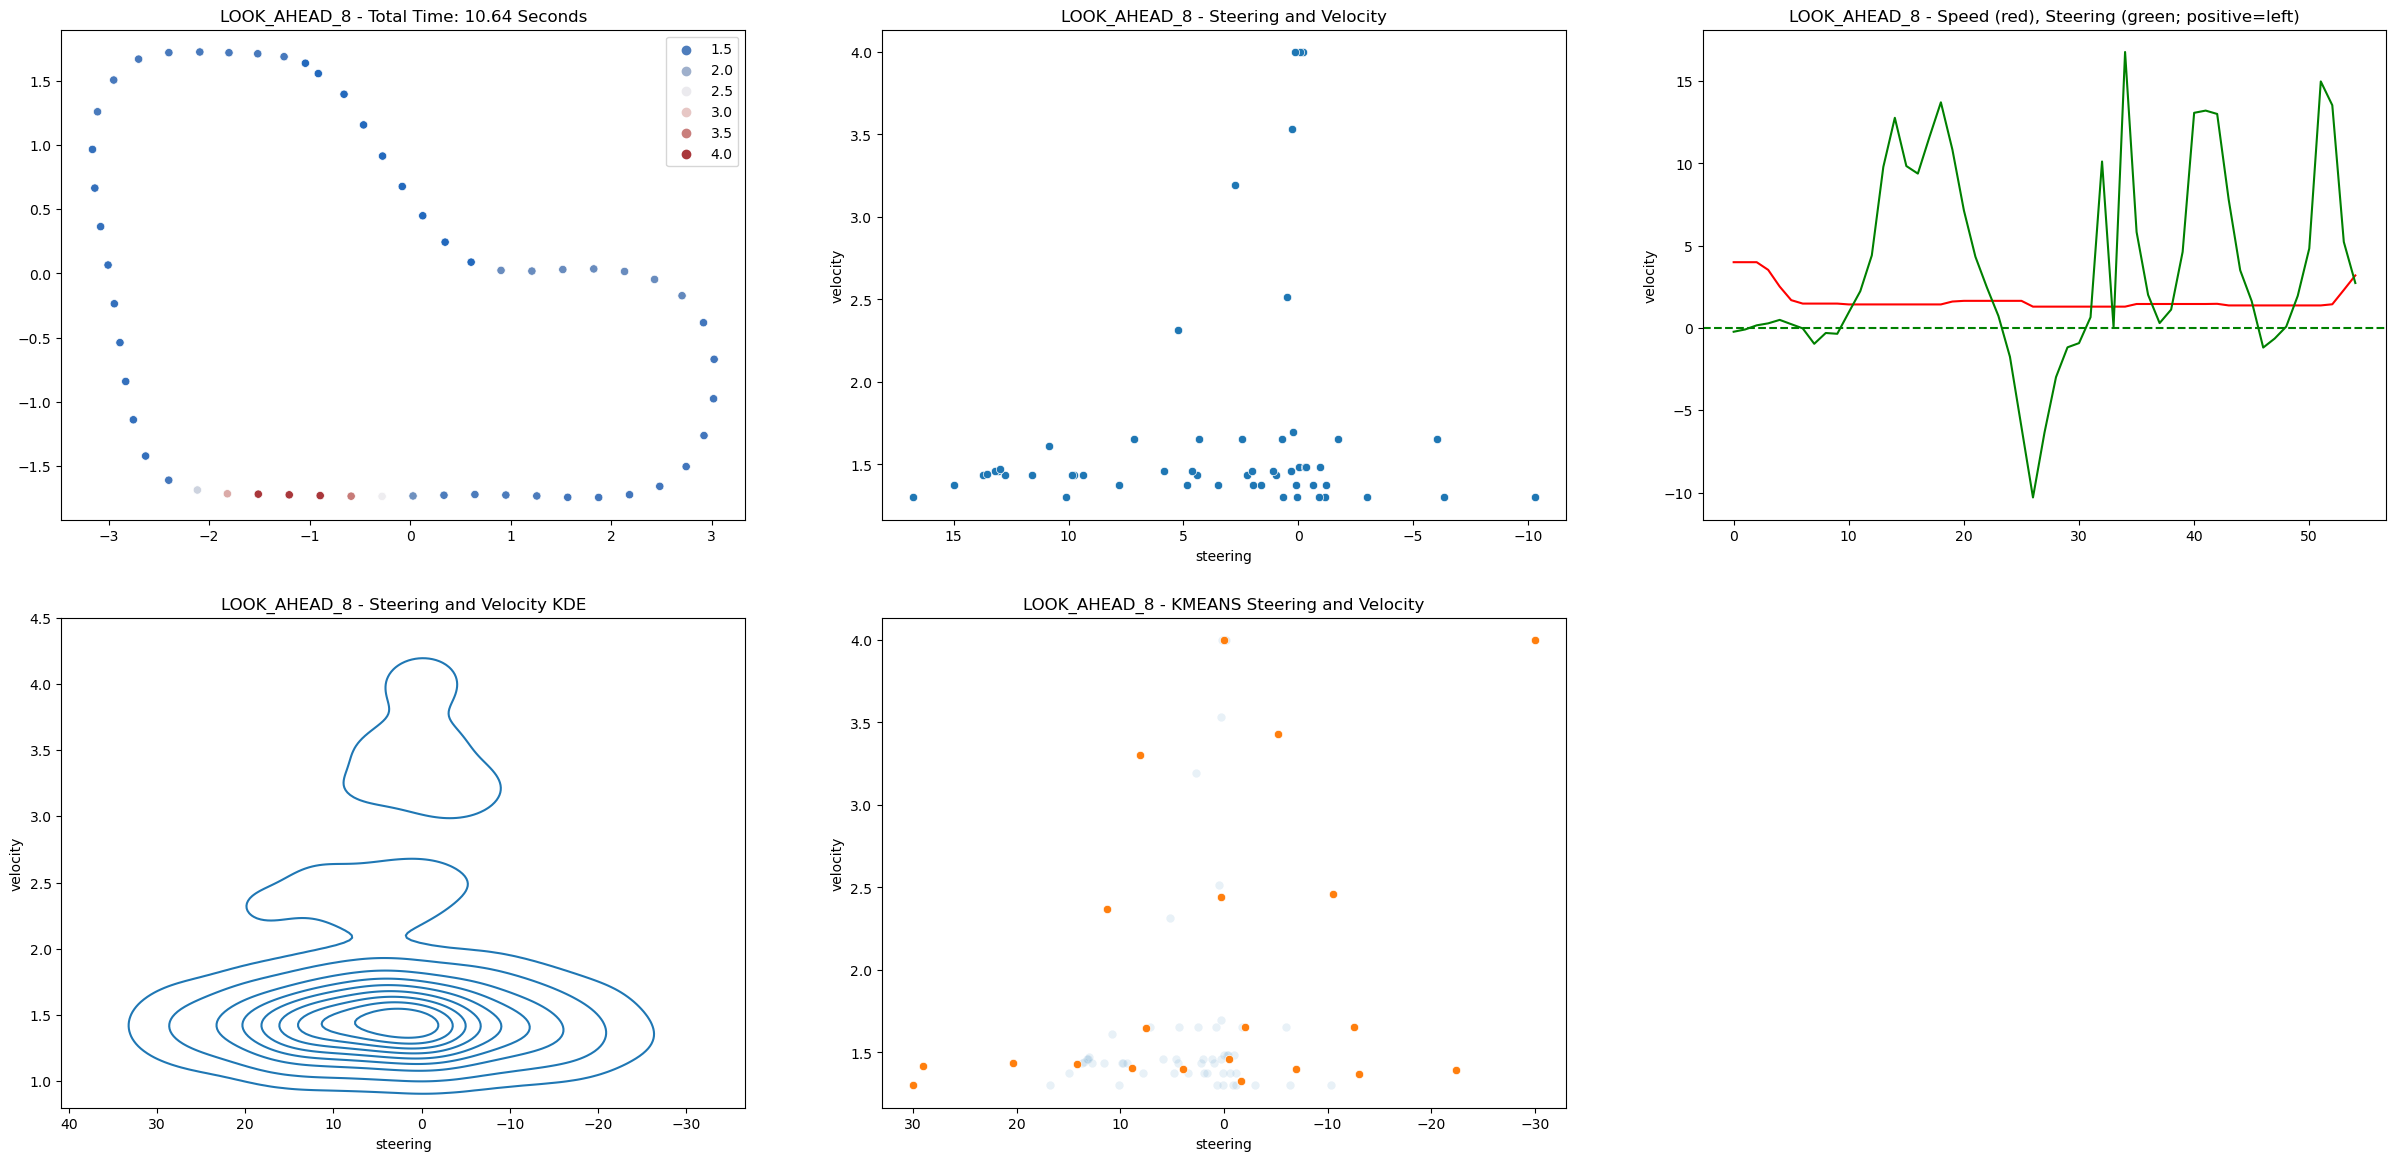

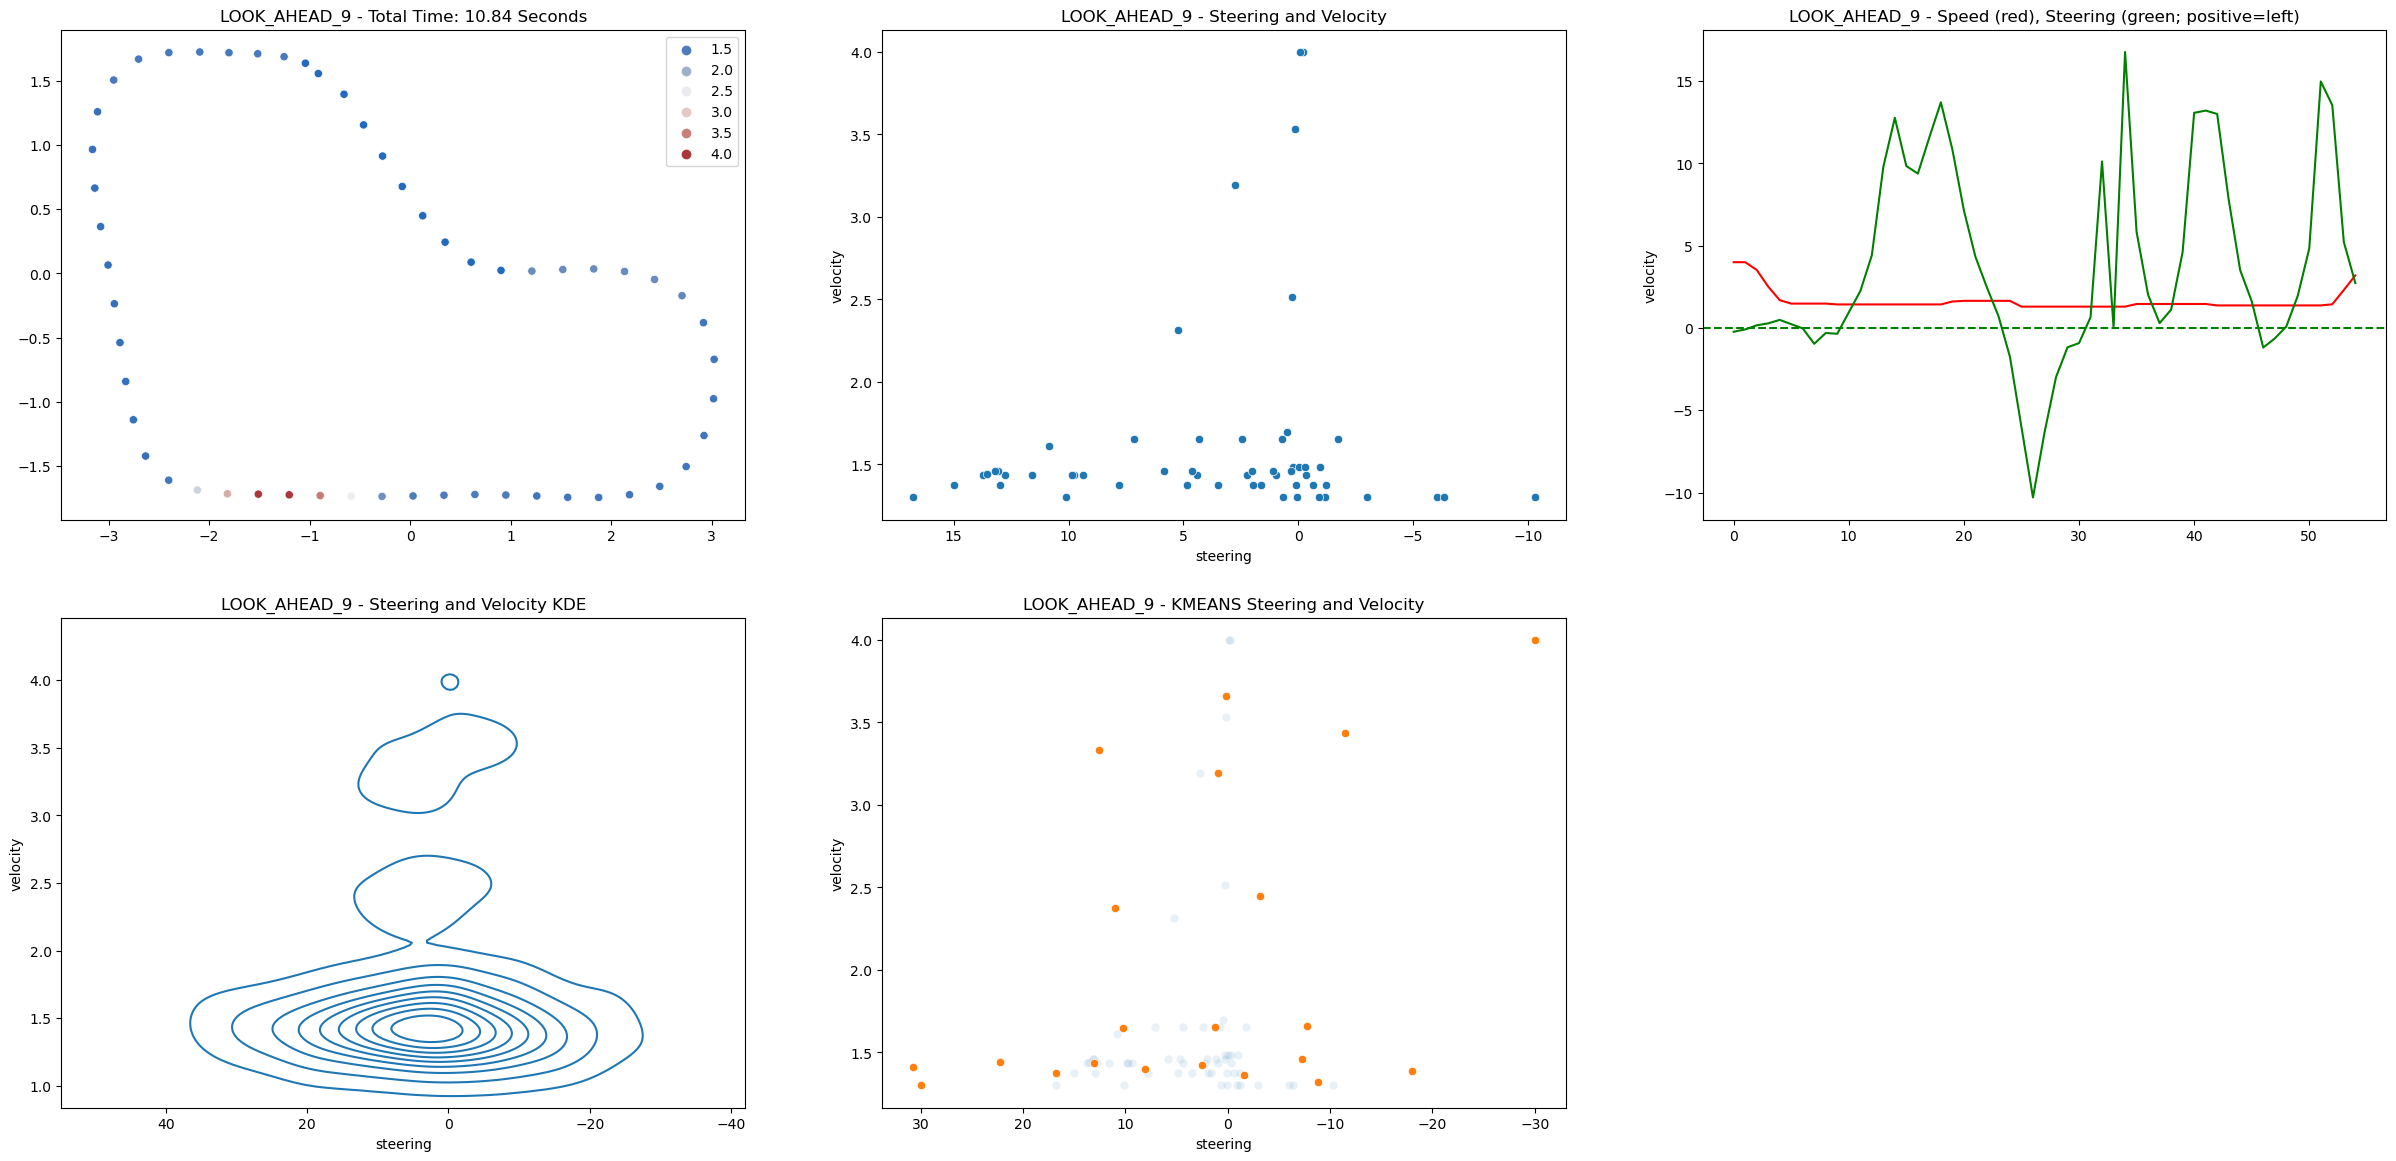

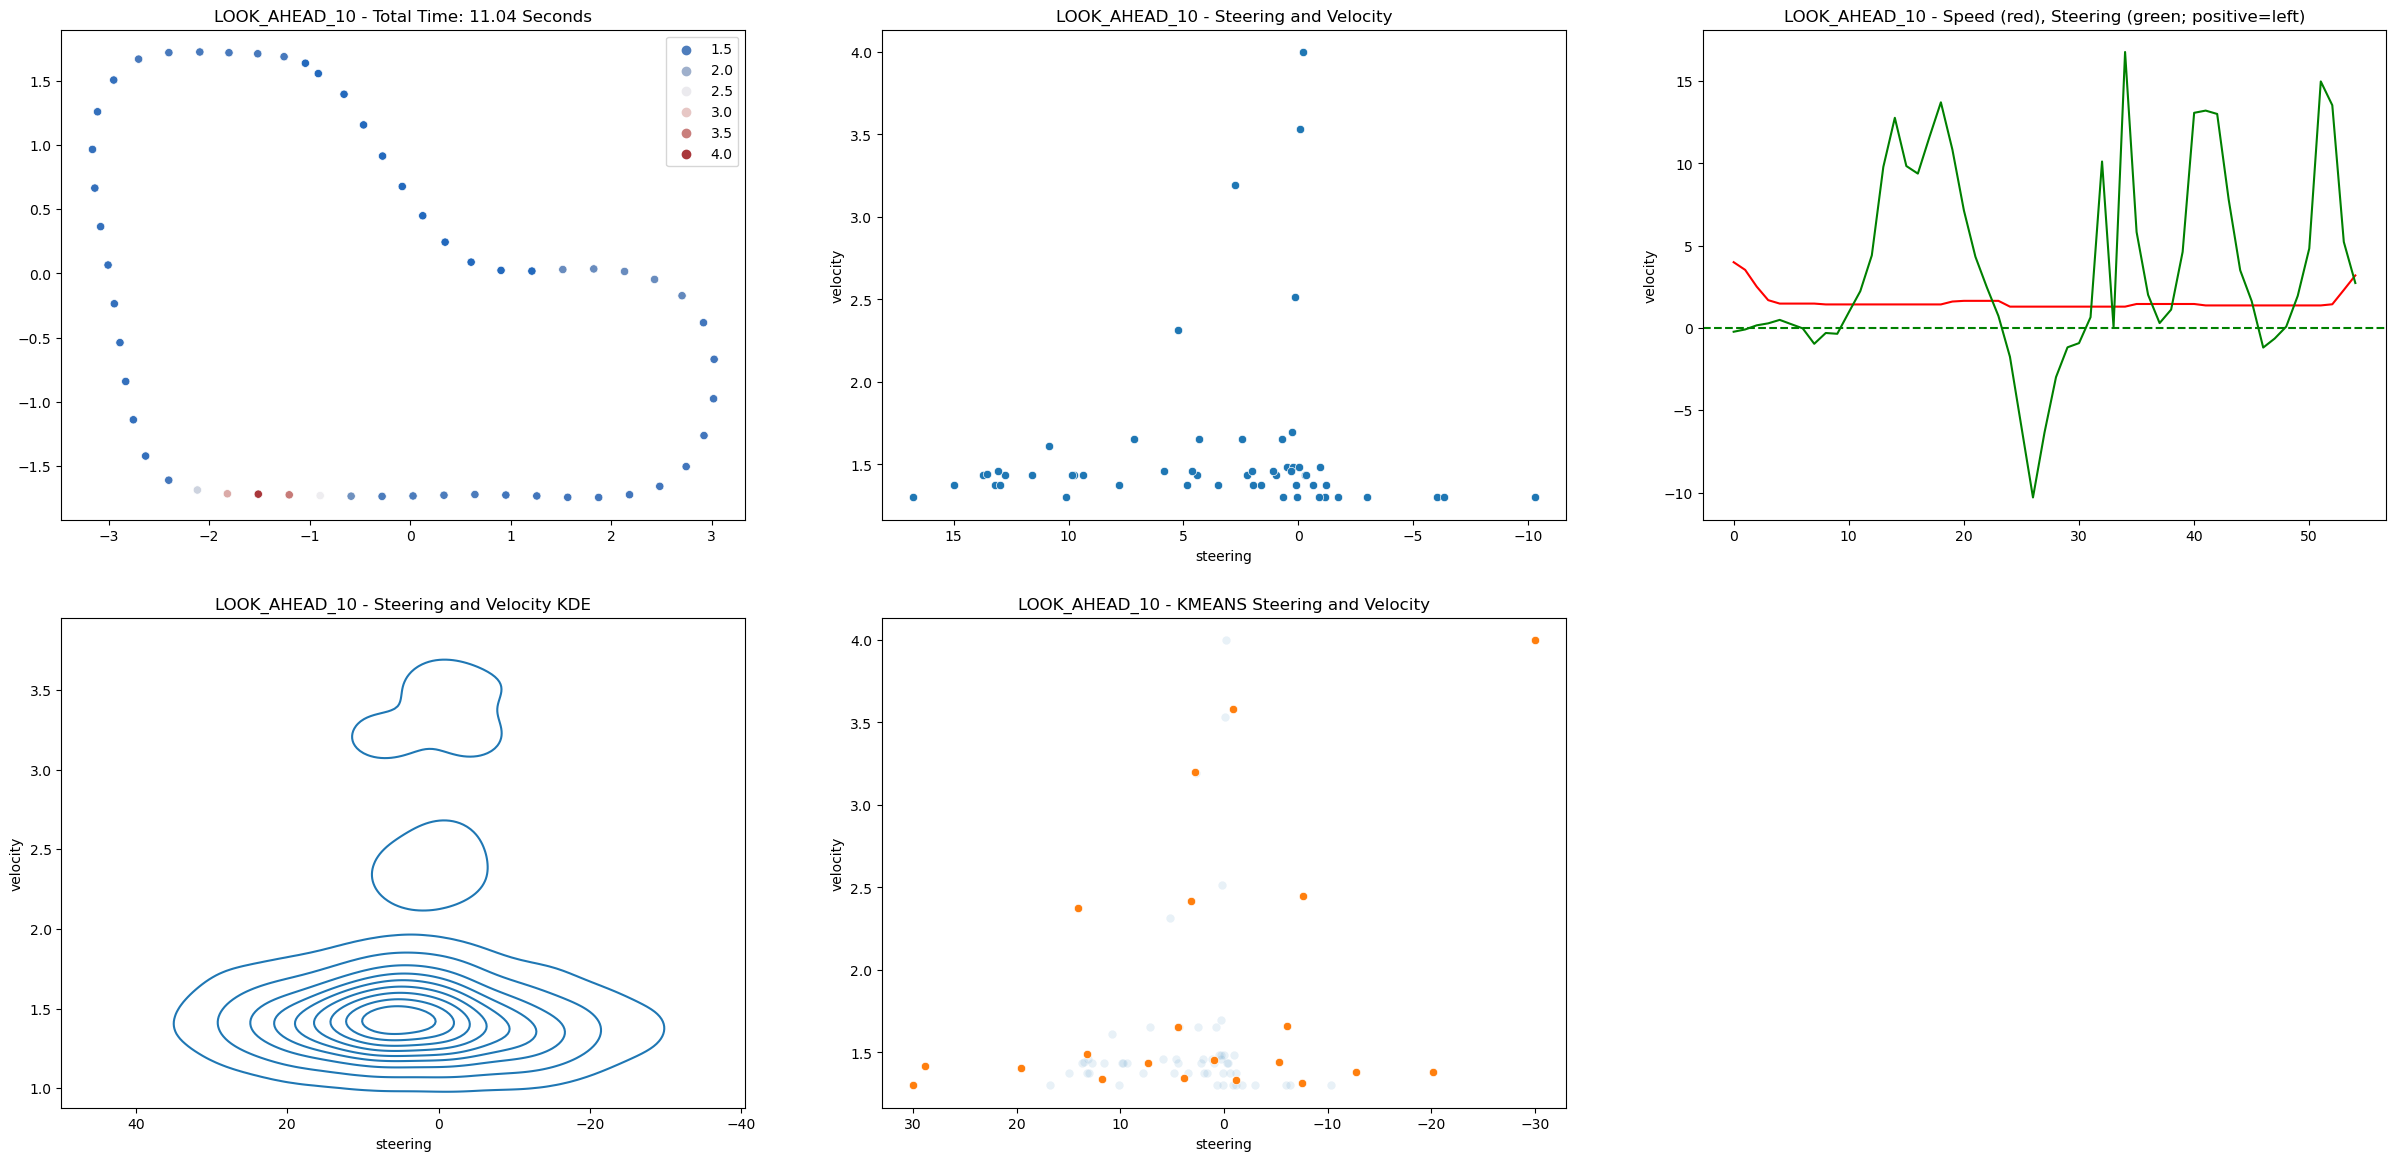

In [22]:
from helpers.utilities.actionspace import create_velocity_profiles

profiles = create_velocity_profiles(OPTIMAL_SPEED_VARS, size=(30, 14))

In [23]:
OPTIMAL_SPEED_VARS["OPTIMAL_SPEED_VELOCITY_FIGS"] = profiles

## Verify which Look Ahead target you want based on the emitted graphs above

In [24]:
OPTIMAL_SPEED_VARS['OPTIMAL_SPEED_TARGET_LOOK_AHEAD_POINTS'] = 2

## Save the raceline package

In [ ]:
RACE_PACKAGE = {
    'VERSIONS': versions,
    'GLOBAL_VARS': GLOBAL_VARS,
    'TRACK_VARS': TRACK_VARS,
    'RACE_LINE_VARS': RACE_LINE_VARS
}

In [ ]:
from helpers.utilities import save_racepack

metadata = save_racepack(RACE_PACKAGE)

print(f'package name: {metadata["package_name"]}')

# Load saved racepack package

In [ ]:
TRACK_NAME = "reInvent2019_wide_ccw" # example: "reInvent2019_wide_ccw"
PACKAGE_NAME = '2c257e04-ad77-4c64-9b35-01f662035fd4_20230317_013848' # example: "467605c5-ecf4-40b1-8370-71199e6f7e96_20230317_013017"
PACKAGE_LOCATION = f"../data/racepack/{TRACK_NAME}/{PACKAGE_NAME}/package.racepack.pickle.gz"

In [ ]:
from helpers.utilities import load_package

loaded_racepack = load_package(PACKAGE_LOCATION)

In [ ]:
display(loaded_racepack["RACE_LINE_VARS"]["RACE_LINE_IMPROVED_FIG"])

In [ ]:
loaded_racepack["RACE_LINE_VARS"]["RACE_LINE_IMPROVED_FIG"].savefig("fig.png")